# **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from typing import *
import scipy.stats as scistat
from scipy import special
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
import pymysql

# **Importing Dataset**

In [3]:
# MySQL connection details
host='localhost'
user='Tvan'
password='Tvan217desu~'
database='personal_finance'

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")  #<- Create engine for MySQL connection

query = "SELECT * FROM dummy_transactions"                                      #<- SQL query to fetch data from transactions table
df = pd.read_sql(query, con=engine)                                             #<- Read data into a DataFrame

df

,trans_no,date,details,amount,transaction,transaction_mode
0,1,9/14/2023,サラリー,17732,Income,Bank
1,2,10/9/2023,サラリー,12754,Income,Bank
2,3,10/15/2023,bank withdraw,26142,Withdraw,Bank
3,4,10/15/2023,stash deposit,26142,Deposit,Stash
4,5,10/31/2023,サラリー,12834,Income,Bank
...,...,...,...,...,...,...
695,696,1/24/2025,paperworld,58,Expenses,Stash
696,697,1/24/2025,photocopy,18,Expenses,Stash
697,698,1/24/2025,pasahe,20,Expenses,Stash
698,699,1/25/2025,Gcash cash-in,3400,Deposit,G-cash


# **Data Cleaning**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   trans_no          700 non-null    int64 
 1   date              700 non-null    object
 2   details           700 non-null    object
 3   amount            700 non-null    int64 
 4   transaction       700 non-null    object
 5   transaction_mode  700 non-null    object
dtypes: int64(2), object(4)
memory usage: 32.9+ KB


In [5]:
# Converting `date` column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')      #<- Convert `date` column to datetime format

# Appending `year`, `month`, and `day` data from the dataset
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

# Creating and Appending str date data
ymd = []                                                        #<- `ymd` means year, month, and day (YY/MM/DD)
ym = []                                                         #<- `ym` means year and month (YY/MM)

# Editing and Adding New Column Entry (Extracting Data)
detail_clean = []
for i, detail in df.iterrows():
    ym.append(f"{str(detail['year'])[2:]}/{detail['month']}")                   #<- Appending `YY/MM`
    ymd.append(f"{str(detail['year'])[2:]}/{detail['month']}/{detail['day']}")  #<- Appending `YY/MM/DD`

    detail_lower = detail['details'].lower()                    #<- Convert details to lowercase for uniformity
    if detail_lower == 'supa':                                  #<- Check if detail is 'supa'       
        detail_clean.append('Supa')
    elif detail_lower[:len('steam')] == 'steam':                #<- Check if detail starts with 'steam'
        detail_clean.append('Steam')
    elif detail_lower[:len('aragmot')] == 'aragmot':            #<- Check if detail starts with 'aragmot'
        detail_clean.append('Aragmot')
    elif detail_lower[:len('gcash cash-out')] == 'gcash cash-out':  #<- Check if detail starts with 'gcash cash-out'
        detail_clean.append('Gcash cash-out')
    elif detail_lower[-len('cash-in'):] == 'cash-in' or detail_lower[:len('gcash')] == 'gcash': #<- Check if detail ends with 'cash-in' or starts with 'gcash'
        detail_clean.append('Gcash cash-in')
    else:
        detail_clean.append(detail['details'])

df['detail_clean'] = detail_clean                               #<- Appending cleaned details to the DataFrame
df['y/m'] = ym                                                  #<- Appending Year/Month (YY/MM) to the DataFrame
df['y/m/d'] = ymd                                               #<- Appending Year/Month/Day (YY/MM/DD) to the DataFrame 

# Date Sorting No. (from earlier to current date)
date_arrangement = {}                                           #<- Dictionary to hold date arrangements for sorting
for i, date in enumerate(df['y/m'].unique().tolist()):          #<- Enumerate through unique dates in 'y/m' column
    date_arrangement[date] = i                                  

df['month sort no.'] = df['y/m'].map(date_arrangement)          #<- Appending Date Sorting No.

df

,trans_no,date,details,amount,transaction,transaction_mode,month,day,year,detail_clean,y/m,y/m/d,month sort no.
0,1,2023-09-14,サラリー,17732,Income,Bank,9,14,2023,サラリー,23/9,23/9/14,0
1,2,2023-10-09,サラリー,12754,Income,Bank,10,9,2023,サラリー,23/10,23/10/9,1
2,3,2023-10-15,bank withdraw,26142,Withdraw,Bank,10,15,2023,bank withdraw,23/10,23/10/15,1
3,4,2023-10-15,stash deposit,26142,Deposit,Stash,10,15,2023,stash deposit,23/10,23/10/15,1
4,5,2023-10-31,サラリー,12834,Income,Bank,10,31,2023,サラリー,23/10,23/10/31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,696,2025-01-24,paperworld,58,Expenses,Stash,1,24,2025,paperworld,25/1,25/1/24,16
696,697,2025-01-24,photocopy,18,Expenses,Stash,1,24,2025,photocopy,25/1,25/1/24,16
697,698,2025-01-24,pasahe,20,Expenses,Stash,1,24,2025,pasahe,25/1,25/1/24,16
698,699,2025-01-25,Gcash cash-in,3400,Deposit,G-cash,1,25,2025,Gcash cash-in,25/1,25/1/25,16


# **Class and Functional Programming**

In [ ]:
# Class Programming for Calc and Printing Mean and Standard Deviation
class StatsSummary:
    """Prints statistic summary (*mean*, *std*, *median*)
    
    ### **Parameter:**
    `data`
    - `DataFrame`, `dict`, or `array` type
    - the data to get its statistic summary
    -----------
    ### **Methods**

    **`print_stats()`**
        - prints statistic summary

    **`<class var>.data`**
        - get data
    **`<class var>.mean`**
        - get mean of data

    **`<class var>.median`**
        - get median of data

    **`<class var>.std`**
        - get standard deviation of data

    **`<class var>.stats`**
        - get dictionary of statistic summary"""

    def __init__(self, data) -> None:                           #<- Instantiation
        self.data = data                                        #<- Data
        self.stat_summary = data.describe()                     #<- Count, mean, std, min, 25%, 50%, 75%, max
        self.mean = np.mean(data)                               #<- Mean
        self.median = np.median(data)                           #<- Median
        self.std = np.std(data, ddof=1)                         #<- Std (1 degree of freedom)
        self.mad = scistat.median_abs_deviation(data)           #<- Median Absolute Deviation
        self.skew = scistat.skew(data)                          #<- Skewness
        self.kurtosis = scistat.kurtosis(data, fisher=True)     #<- Kurtosis (Fisher's definition)
        self.stats: dict = {'Mean': self.mean,                  #<- Dictionary for statistics summary
                            'Standard Deviation': self.std, 
                            'Median': self.median,
                            'MAD': self.mad,
                            'Skewness': self.skew,
                            'Kurtosis': self.kurtosis,
                            'Mean-Median Gap': np.abs(self.mean - self.median) / self.mean}
    

    def print_stats(self, mean: bool=True, std: bool=True, 
                    median: bool=False, mad: bool=False, skew: bool=True, 
                    kurtosis: bool=True, mean_median_gap: bool=True, round_digit:int = False) -> None:
        """Prints statistic summary.
        - Mean
        - Standard Deviation
        - Median
        - Median Absolute Deviation (MAD)
        - Skewness"""
        
        stats = {'Mean': mean, 'Standard Deviation': std, 'Median': median, 
                 'MAD': mad, 'Skewness': skew, 'Kurtosis': kurtosis, 'Mean-Median Gap': mean_median_gap}     #<- Dict for mean, std, and mean param checking

        for stat_key, stat in stats.items():                                    #<- Iter "stats" dict
            if stat:                                                            #<- Checks if mean, std, median param are true
                if type(round_digit) == int or round_digit == True :            #<- Checks "round_digit" type if int or it is True

                    if type(round_digit) != int:
                        print('WARNING!: `round_digit` must be an int not bool. Setting `round_digit` to 0.\n') #<- Warning message 
                        round_digit = 0                                                     #<- Setting to 0 since "True" can't mathematically operatable

                    print(f"{stat_key} = {np.round(self.stats[stat_key], round_digit):,}")    #<- Prints rounded value
                else:
                    print(f"{stat_key} = {self.stats[stat_key]:,}")                           #<- Prints value as is

    
def plot_line_bar(dataset: pd.DataFrame, x:str, y:str, plot_title: str|list, fig_size:tuple=(10, 6)) -> None:
    """## **Function:**
    - Plotting line and bar graphs using `sns.lineplot()` and `sns.barplot()` in subplots.
    ---------
    ## **Parameters:**
    - `dataset=`
        - `pd.DataFrame` type
        - The data you want to plot.
    
    - `x=`
        - `str` type
        - The column name for the x-axis.
    
    - `y=`
        - `str` type
        - The column name for the y-axis.
    
    - `plot_title=`
        - `str` or `list` type
        - The title of the plot.
    
    - `fig_size=`
        - `tuple` type
            - Example: `(<row_int>, <col_int>)`
        - The size of the figure.
        - default: `(10, 6)`"""
    
    fig, ax = plt.subplots(2, 1, figsize=fig_size)                                      #<- Subplots with 1 row and 2 columns

    plt1 = sns.lineplot(data=dataset, x=x, y=y, marker='o', ax=ax[0])                   #<- Line plot with markers
    plt1.axhline(dataset[y].mean(), color='red', linestyle='--', label='Mean')          #<- Mean line
    plt1.axhline(dataset[y].median(), color='gray', linestyle='--', label='Median')     #<- Median line
    plt1.set_title(f"Line Graph: {plot_title}")                                         #<- Title setting
    plt1.legend()                                                                       #<- Legend for mean and median lines

    plt2 = sns.barplot(data=dataset, x=x, y=y, ax=ax[1])                                #<- Bar plot
    for bar in plt2.patches:                                       #<- Data labels
        height = bar.get_height()

        if height > 0:
            plt2.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', va='bottom', ha='center')
    plt2.axhline(dataset[y].mean(), color='red', linestyle='--', label='Mean')          #<- Mean line
    plt2.axhline(dataset[y].median(), color='gray', linestyle='--', label='Median')     #<- Median line
    plt2.set_title(f"Bar Graph: {plot_title}")                                          #<- Title setting for bar plot
    plt2.legend()                                                                       #<- Legend for mean and median lines

    plt.tight_layout()                                                                  #<- Adjust layout to prevent overlap
        

def plot_distribution(data: pd.DataFrame, plot_title:str|list, fig_size: tuple = (10, 5), skew:bool=False, ci:tuple=False) -> None:
        """ ## **Function:**
        - Plotting distribution using `sns.histplot()` and `sns.boxplot()` in subplots.
        ---------
        ## **Parameters:**
        - `data=`
            - `pd.DataFrame` type
            - The data you want to see the distribution.

        - `plot_title=`
            - `str` or `list` type
            - The title of the plot.

        - `fig_size=`
            - `tuple` type
                - Example: `(<row_int>, <col_int>)`
            - The size of the figure.
            - default: `(10, 5)`
        
        - `skew=`
            - `bool` type
            - If `True`, it will print the skewness of the data.
            - default: `True`"""
        
        dataset: dict = {plot_title: data}

        col_count = len(dataset.keys())     #<- Checking how many data to plot (each row different data)
        iter_count = 0                   

        fig, ax = plt.subplots(2, col_count, figsize=fig_size)      #<- Subplots with 2 columns

        if col_count < 2:                                           #<- If there's only 1 data
            axes = ax[0]
        else:                                                       #<- If there's more than 1 data
            axes = ax[iter_count, 0]

        for key, val in dataset.items():                                                #<- Iter dict "dataset"
            ax0 = sns.histplot(val, ax=axes, bins=30, kde=True)                         #<- Histogram
            ax0.set_title(key)                                                          #<- Title setting
            ax0.axvline(np.mean(val), color='red', linestyle='--', label='Mean')        #<- Mean line
            ax0.axvline(np.median(val), color='gray', linestyle='--', label='Median')   #<- Median line
            ax0.set_title(f'Histogram: {key}')                                          #<- Title setting for histogram
            ax0.legend()                                                                #<- Legend for mean and median lines

            if col_count < 2:                                                           #<- Incrementation for 1 data distribution check
                axes = ax[1]

            ax1 = sns.boxplot(x=val, ax=axes)                                           #<- Box plot
            ax1.set_title(key)                                                          #<- Title setting
            ax1.axvline(np.mean(val), color='red', linestyle='--', label='Mean')        #<- Mean line
            ax1.set_title(f'Box Plot: {key}')                                           #<- Title setting for box plot
            ax1.legend()                                                                #<- Legend for mean line

            if ci:
                for intrvl in ci:
                    ax0.axvline(intrvl, color='red', linestyle='--')
                    ax1.axvline(intrvl, color='red', linestyle='--')
            
            iter_count += 1
            
            if skew:
                print(f"Skewness = {np.round(scistat.skew(val), 3)}")                   #<- Print skewness of the data
            
        plt.tight_layout()


class HypothesisTest:
    """## Function
    - Uses parametric and non-parametric tests for hypothesis testing.
    --------
    ## Parameters  

    `data`
        - the data  
        - `pd.DataFrame` or `pd.Series` type

    `null_value`
        - the null hypothesis value or assummed value.    
        - `int` or `float` type    
    
    `alpha`   
        - the confidence level
        - `float` type
        - default = *0.05*
    ---------
    ## Methods and Functions
    
    `<class var>.data`
        - Get the data

    `<class var>.null_value`
        - Get the null hypothesis or assummed value.

    `<class var>.alpha`
        - Get the confidence interval.

    `<class var>.binomial_tests()`

    `<class var>.ttest_1sample()`

    `<class var>.wilcoxon_test()`

    `<class var>.check_autocorrelation_plot()`
    
    `<class var>.permutation_test()`"""

    def __init__(self, data: pd.DataFrame|pd.Series, null_value: int|float, alpha: float=0.05) -> None:
        self.data = data
        self.null_value = null_value
        self.alpha = alpha


    def binomial_test(self, alternative="less") -> scistat._binomtest.BinomTestResult:              
        diff = [x - self.null_value for x in self.data]                                             #<- List of difference of data and assumed (x - assumed)
        pos = sum(d > 0 for d in diff)                                                              #<- Number of data ABOVE 0 difference
        neg = sum(d < 0 for d in diff)                                                              #<- Number of data BELOW 0 difference

        n = pos + neg                                                                               #<- Number of data EITHER below or above 0 difference
        return scistat.binomtest(min(pos, neg), n=n, p=0.5, alternative=alternative)                #<- Binomial result
    

    def ttest_1sample(self, alternative='two-sided') -> scistat._stats_py.TtestResult:
        return scistat.ttest_1samp(a=self.data, popmean=self.null_value, alternative=alternative)   


    def wilcoxon_test(self, alternative="two-sided") -> scistat._morestats.WilcoxonResult:
        return scistat.wilcoxon(x=self.data - self.null_value, alternative=alternative)
    

    def check_autocorrelation_plot(self, plot_title=None) -> None:
        pd.plotting.autocorrelation_plot(series=self.data, marker='o')
        
        if plot_title:
            plt.title(f'Autocorrelation Plot of {plot_title}')


    def permutation_test(self) -> None:
        # Step 1: Observed number of months earning <= ₱21,000
        observed_stat = np.sum(self.data <= self.null_value)

        # Step 2: Permutation test
        n_permutations = 10000
        permuted_stats = []

        for _ in range(n_permutations):
            # Shuffle the earnings
            permuted = np.random.permutation(self.data)
            
            # Randomly select same number of values as in observed_stat
            sampled = np.random.choice(permuted, size=len(self.data), replace=True)

            # Count how many values are <= ₱21,000
            stat = np.sum(sampled <= self.null_value)
            permuted_stats.append(stat)

        permuted_stats = np.array(permuted_stats)

        # Step 3: Calculate p-value (how extreme is the observed stat?)
        p_value = np.mean(permuted_stats >= observed_stat)

        # Step 4: Plot
        plt.hist(permuted_stats, bins=20, color='lightgray', edgecolor='black')
        plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label=f'Observed = {observed_stat}')
        plt.title('Permutation Test - Earnings ≤ ₱21,000')
        plt.xlabel('Number of Months')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        print(f"P-value: {p_value:.4f}")
        return p_value


def interp_pvalue(p_value, alpha:float = 0.05) -> None:
    """Checks if to **reject** or **fail to reject** null hypothesis."""

    if alpha < p_value:
        print(f"Fail to Reject Null Hypothesis. alpha < p-value is {alpha < p_value}")
    else:
        print(f"Reject Null Hypothesis. alpha < p-value is {alpha < p_value}")

# **Data Analysis**
### `transactions`
Visualizing transactions data
- Let's view the progress of the records so far.

In [7]:
# Grouping by `transaction` and Summing up the Amount
transactions = df.groupby('transaction')['amount'].agg(['sum', 'count'])    #<- Grouping by transaction and summing the amount, also counting the number of
transactions.columns = ['Total Amount', 'Total Transactions Conducted']     #<- Renaming columns for clarity
transactions

,Total Amount,Total Transactions Conducted
transaction,,
Deposit,320179,24
Expenses,261875,608
Income,619267,44
Withdraw,405004,24


,Total Amount,Total Transactions Conducted
transaction,,
Deposit,320179,24
Expenses,261875,608
Income,619267,44
Withdraw,405004,24


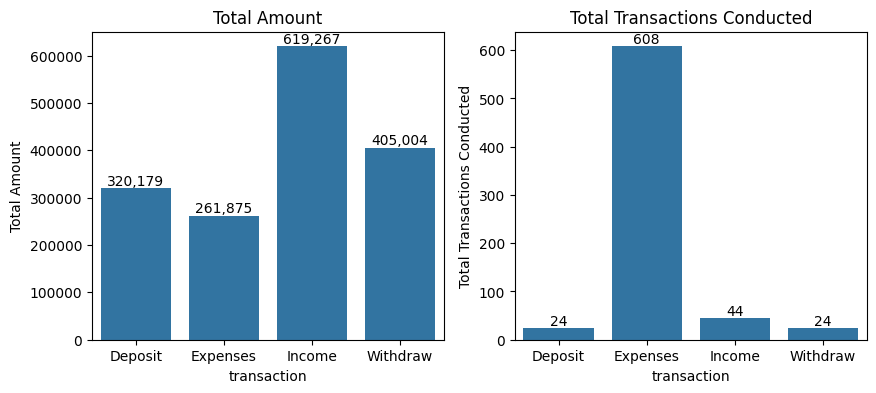

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))                       #<- Setting figure size for bar plot

# Bar Plotting the Data
for idx, col in enumerate(transactions.columns):                    #<- Iterating through columns of transactions DataFrame
    trans = sns.barplot(data=transactions[col], ax=ax[idx])         #<- Bar plot
    for bar in trans.patches:                                       #<- Data labels
        height = bar.get_height()

        if height > 0:
            trans.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', va='bottom', ha='center')
    trans.set_title(col)

transactions

### Descriptive Interpretation
- So far, the **highest recorded total amount is the Income category**.
    - Total amount of $\text{Php}\: 619,267$ of gross income.
    - If Expenses category is higher than Income, it could mean I am spending more than earning.
        - Total expenses is $\text{Php}\: 261,875$.

- So far, the **highest recorded transaction is the expenses category**.
    - Total of $608$ recorded transactions.

### **Analyzing Net Income**
Columns involve:
- `'transaction'`
- `'y/m'`
- `'month sort no.'`

In [9]:
test_month_sort = df[['y/m', 'month sort no.']].set_index('y/m').to_dict()['month sort no.'] #<- Creating a dictionary for month sorting based on 'y/m' and 'month sort no.' columns
test_df = df[(df['transaction'] == 'Income') | (df['transaction'] == 'Expenses')]           #<- Filtering DataFrame for 'Income' and 'Expenses' transactions
test_piv = test_df.pivot_table(index='y/m',                                                 #<- Pivoting the DataFrame to have 'y/m' as index
                               columns='transaction', 
                               values='amount', 
                               aggfunc='sum').reset_index().dropna(subset=['Expenses'])

test_piv['month_sort'] = test_piv['y/m'].map(test_month_sort)                               #<- Mapping month sort to pivot table DataFrame
test_piv = test_piv.set_index('month_sort').sort_index()                                    #<- Setting index to 'month_sort' and sorting the DataFrame
test_piv['Net'] = test_piv['Income'] - test_piv['Expenses']                                 #<- Calculating Net Income
test_piv

transaction,y/m,Expenses,Income,Net
month_sort,,,,
2,23/11,10181.0,70026.0,59845.0
3,23/12,32023.0,43465.0,11442.0
4,24/1,9647.0,25466.0,15819.0
5,24/2,17583.0,25195.0,7612.0
6,24/3,18789.0,25195.0,6406.0
7,24/4,16059.0,32231.0,16172.0
8,24/5,12242.0,52230.0,39988.0
9,24/6,20411.0,25231.0,4820.0
10,24/7,21985.0,30278.0,8293.0


Mean Net Income = Php 20,938.13
Median Net Income = Php 15,819.00


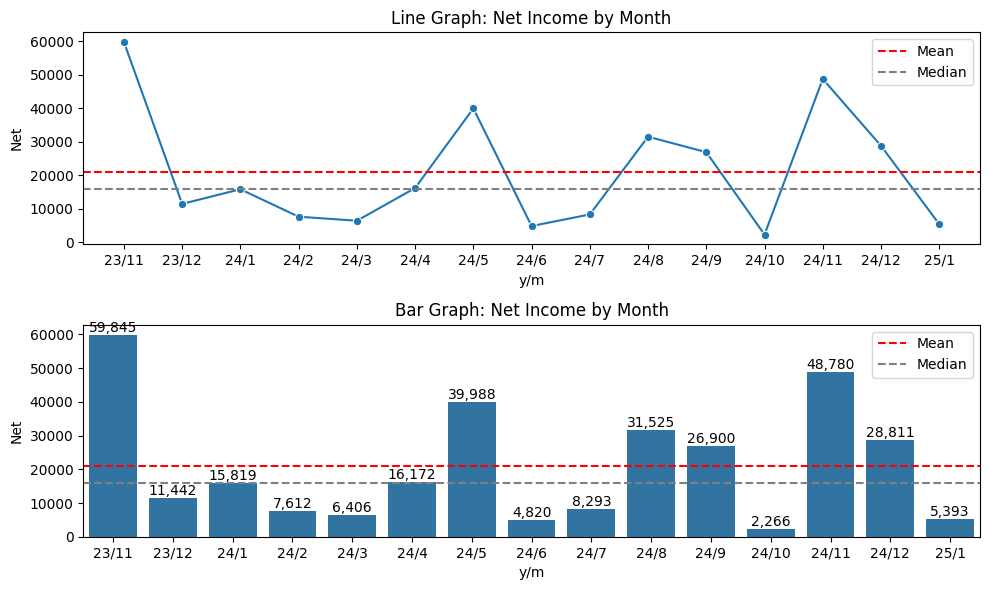

In [10]:
plot_line_bar(dataset=test_piv, x='y/m', y='Net', plot_title='Net Income by Month')  #<- Plotting Net Income by Month

# Terminal Output
print(f'Mean Net Income = Php {test_piv['Net'].mean():,.2f}')
print(f'Median Net Income = Php {test_piv['Net'].median():,.2f}')

### Descriptive Interpretation:
- **All months have positive net income**.
    - Net income is the **amount of money left after subtracting all expenses from total income** over a specific period.
    - Could mean I saved these remaining monthly balance.

- Seems like there are more months that have net income values around $1000$ net income.
    - Placing median line would be worth to try.
    - It is also worth to view the distributions of this data.

### Distribution of Monthly Net Income

Median = 15,819.0
MAD = 10,999.0
Skewness = 0.88
Kurtosis = -0.36
Mean-Median Gap = 0.24


count       15.00
mean     20938.13
std      17726.65
min       2266.00
25%       7009.00
50%      15819.00
75%      30168.00
max      59845.00
Name: Net, dtype: float64

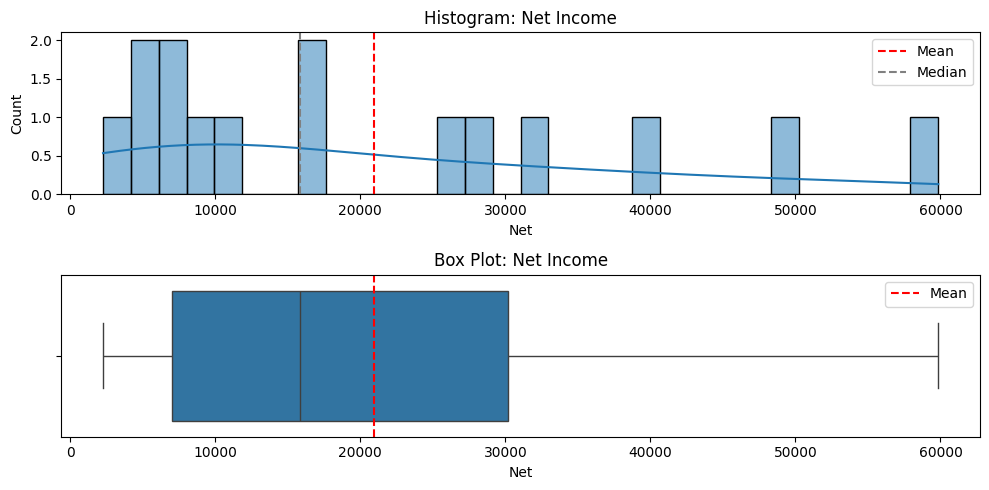

In [11]:
# Plotting Distribution of Net Income
plot_distribution(data=test_piv['Net'], plot_title='Net Income')    #<- Plotting distribution of Net Income

# Statistics Summary
stats_summary = StatsSummary(test_piv['Net'])                                   #<- Creating an instance of StatsSummary for Net Income
stats_summary.print_stats(mean=False, std=False,                                #<- Printing statistics summary for Net Income
                          median=True, mad=True, round_digit=2)
stats_summary.stat_summary.round(2)

### Descriptive Interpretation:
- ⚠️**Sample size is $15$.**
    - Around sample size of $30$ is considered that the data starting to form roughly normal distribution.
    - **Sample size of $15$ is risky to consider that the data is roughly normal.**

- ⚠️**Skewness is $0.88$**.
    - **Distribution is mildly skewed to the right** (also called positively skewed).
    - It is beyond from 0 to 0.5 values to be considered as roughly normal.
    - Median central tendency would be better.
        - Mean is sensitive towards skews and outliers, resulting to misleading interpretation.
    - Parametric tests and confidence interval are not reliable in this kind of distribution.
        - Using non-parametric tests and bootstrap CI would be much reliable.

- ✅**Kurtosis is $-0.36$**.
    - The tailedness of the data.
        - $>0$ kurtosis.
            - Data can be present on the extremes.
            - Can distort mean and widens standard deviation.
            - Makes mean less reliable as central tendency of the data.
        - $<0$ kurtosis.
            - Data are more concentrated at the center value.
            - Less data on the extremes.
            - Sampling bias could be present if too far from 0.
    - $-0.36$ is between $0$ and $-1$.
        - **Can be safely say the distribution have light tails**.
            - There are no outliers on the data.

- 🚩**Mean-median gap is $24$%**.
    - The value is beyond $20$% to be considered as close together.
        - Mean is being pulled by non-typical data.
        - This **makes our mean to be less reliable as central tendency**.
            - Using **median as central tendency would be better and more reliable**.
            - Using non-parametric tests and bootstrap CI are safer route if inferences needed.

- **Median value is $\text{Php}\: 15,819$.**
    - The middle value of the data.
    - **Typically have monthly net income around $\text{Php}\: 15,819$**.

- **MAD (Median Absolute Deviation) value is $\text{Php}\: 10,999$.**
    - About how much the the net income varies in each month from the median.
    - This means **monthly net income may typically vary around $\text{Php}\: 10,999$ above or below $\text{Php}\: 15,819$.**

- **IQR is from $\text{Php}\: 7,009.5$ to $\text{Php}\: 30,168$.**
    - The range where 50% values (the half proportion) of the data lies.
    - In other words, the **typical monthly net income is between $\text{Php}\: 7,009.5$ and $\text{Php}\: 30,168$.**

- **In Summary:**
    - The data distribution is **mildly skewed to the right**
    - **Typically have monthly net income around $\text{Php}\: 15,819$**.
    - Monthly net income may **typically vary around $\text{Php}\: 10,999$** above or below $\text{Php}\: 15,819$.
    - **Typical monthly net income is between $\text{Php}\: 7,009.5$ and $\text{Php}\: 30,168$.**

## **`Expenses` transactions**
### Monthly Expenses

In [12]:
# Extracting `Expenses` and Make DF
df_expenses = df.loc[df['transaction'] == 'Expenses']

# Group by str `y/m` and Sum their Amount
grpby_expen_by_month = df_expenses.groupby('y/m')['amount'].sum().reset_index()             #<- Grouping by 'y/m' and summing the 'amount' for Expenses

grpby_expen_by_month['date sort no.'] = grpby_expen_by_month['y/m'].map(date_arrangement)   #<- Appending Date Sorting No. for sorting
grpby_expen_by_month = grpby_expen_by_month.sort_values(by='date sort no.')                 #<- Sorting by Date Sorting No.

grpby_expen_by_month

,y/m,amount,date sort no.
0,23/11,10181,2
1,23/12,32023,3
2,24/1,9647,4
6,24/2,17583,5
7,24/3,18789,6
8,24/4,16059,7
9,24/5,12242,8
10,24/6,20411,9
11,24/7,21985,10
12,24/8,11107,11


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

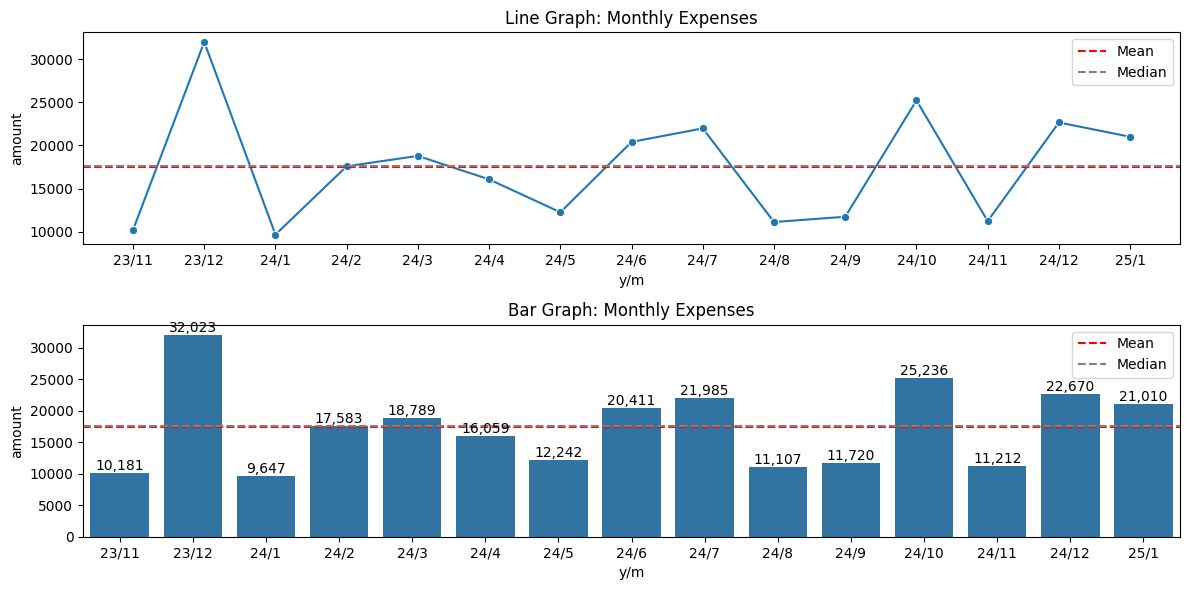

In [13]:
# Setting Mean, Median, and Standard Deviation of Monthly Expenses
stats_monthly_expen = StatsSummary(grpby_expen_by_month['amount'])

# Plotting Monthly Expenses
plot_line_bar(dataset=grpby_expen_by_month, x='y/m', y='amount', plot_title='Monthly Expenses', fig_size=(12, 6))  #<- Plotting Monthly Expenses

# Terminal Output
stats_monthly_expen.stat_summary.round(2)

### Descriptive Interpretation
- **Mean of $\text{Php}\: 17,458.33$.**
    - This means that the **average monthly expenses is $\text{Php}\: 17,458.33$.**

- **Standard deviation of $6,540.11$.**
    - The average variation monthly expenses if it is not equal to the mean, which is either greater than or less than the mean.
    - This means that the **average variation of monthly expenses is $\text{Php}\: 6,540.11$ either above or below $\text{Php}\: 17,458.33$.**

#### **Further Observations:**  
**Line Graph**
1. There are **less variation of monthly expenses from $\text{Feb.}\: 2024\: \text{(24/2)}$ to $\text{Jul.}\: 2024\: \text{(24/7)}$ from the mean**.
    - Are **data points that are not far from the mean line** (the red line).
    - This seems to be the more typical monthly expenses.
    - There have typical monthly expenditures.

2. There are **larger variation of monthly expenses from $\text{Nov.}\: 2023\: \text{(23/11)}$ to $\text{Jan.}\: 2024\: \text{(24/1)}$, and $\text{Sept.}\: 2024\: \text{(24/8)}$ to $\text{Dec.}\: 2024\: \text{(24/12)}$**.
    - These are **data points that are further from the mean line**.
    - The further from the line, the greater variation, and the greater its contribution to increase standard deviation.
    - ***If data point is way greater than the red line,*** either: 
        - *There are greater expenses than usual in that month.*
    - ***If data point is way less than the red line,*** either:
        - *There are lesser expenses than usual in that month.*

**Bar Graph**
- The **highest monthly expenses among these months is $\text{Dec.}\: 2023\: \text{(23/12)}$**.
    - The **month's expenses is around $\text{Php}\: 32,000$**.
        - Almost as much as the double amount of the average monthly expenses.
    - Although, the $\text{Dec.}\: 2024\: \text{(24/12)}$ is just approximately $\text{Php}\: 22,700$.
        - $\text{Dec. 2024}$ is $29$% less than $\text{Dec. 2023}$ in terms of monthly expenses.
    - **Inspecting this specific months from the data table could help us understand the expenditure behaviour.**

Go to [Monthly Expenses Confidence Interval (CI)](###estimating-the-true-monthly-expenses-average-by-using-bootstrap-confidence-interval-(CI))

#### Inspecting Why $\text{Dec.}\: 2023$ is the Highest in Terms of Monthly Expenses.

,Total Amount,Count of Transactions
details,,
balay (nov),5000,1
battery,3600,1
hatag kanda mama,3000,1
SSD,2900,1
laptop keyboard,2600,1
Gasolina (nov),2100,1
Ebo Sweldo,1500,1
laptop upgrade labor,1500,1
medisina,1375,1


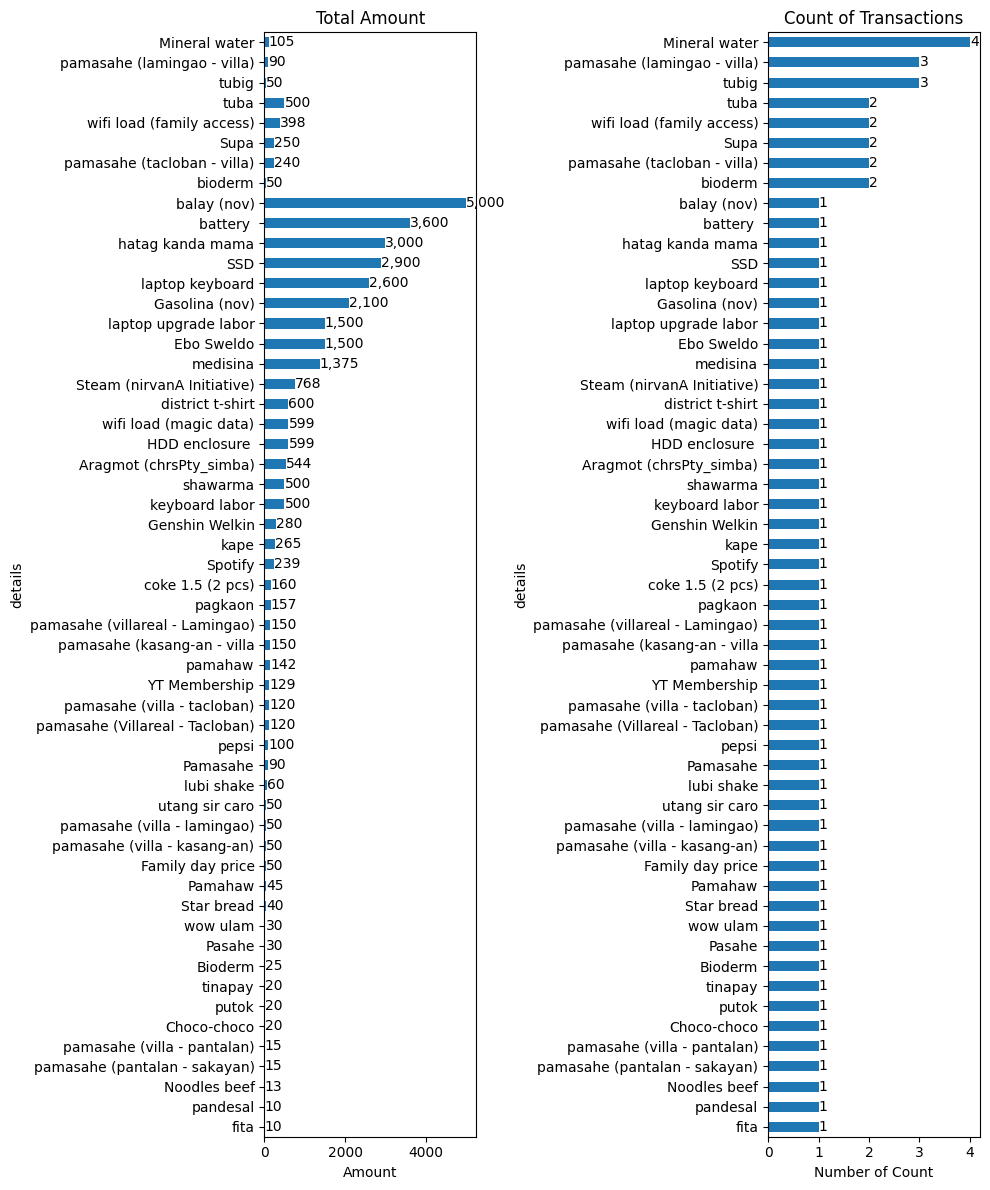

In [14]:
# Setting DataFrame for December 2023 Expenses Details
dec_2023_expen = df_expenses[df_expenses['y/m'] == '23/12']                                     #<- Filtering DataFrame for December 2023 expenses
grpby_dec2023 = dec_2023_expen.groupby('details')['amount'].agg(['sum', 'count']).sort_values(by=['count', 'sum'], ascending=True)  #<- Grouping December 2023 expenses by 'details' and summing the 'amount', also counting the number of transactions, then sorting by count and sum
grpby_dec2023.columns = ['Total Amount', 'Count of Transactions']                               #<- Renaming columns for clarity
x_axis = ['Amount', 'Number of Count']                                                          #<- X-axis labels for bar plot      

# Plotting Total Amount and Counts of Transactions for December 2023 Expenses
fig, ax = plt.subplots(1, 2, figsize=(10, 12))                                                  #<- Setting figure size for bar plot

for idx, col in enumerate(grpby_dec2023.columns):                                               #<- Iterating through columns of grouped DataFrame
    plt0 = grpby_dec2023.reset_index().plot(kind='barh', x='details', y=col, ax=ax[idx])        #<- Plotting bar graph for December 2023 expenses

    for bar in plt0.patches:                                                                    #<- Data labels
        height = bar.get_width()
        if height > 0:
            plt0.text(height, bar.get_y() + bar.get_height()/2, f'{height:,.0f}', va='center', ha='left')

    plt0.set_title(f"{col}")
    plt0.set_xlabel(x_axis[idx])                                                                #<- Setting x-axis label
    plt0.legend().set_visible(False)                                                            #<- Hiding legend for each subplot

plt.tight_layout()

# Terminal Output (Filtered and Sorted December 2023 Expenses Details)
grpby_dec2023[grpby_dec2023['Total Amount'] >= 1000].sort_values(by='Total Amount', ascending=False)  #<- Filtering and sorting December 2023 expenses details with total amount greater than 1000

### Descriptive Interpretation:
- On the filtered data table, it shows transaction in the month of $\text{Dec.}\: 2023$ that have greater than or equal to $\text{Php}\: 1000$ total amount.
    - The unsual expenses are:
        - battery $(\text{Php}\: 3,600)$
        - hatag kanda mama $(\text{Php}\: 3,000)$
        - SSD $(\text{Php}\: 2,900)$
        - laptop keyboard $(\text{Php}\: 2,600)$
        - laptop upgrade labor $(\text{Php}\: 1,500)$
        - medisina $(\text{Php}\: 1,375)$
    - The **unusuals expenses are mostly from laptop repair and parts**.

#### We can safely say:
- **The expenses are higher in $\text{Dec.}\: 2023$ because of laptop repair and upgrade expenses**.

### **Monthly Expenses Distribution**

Mean = 17,458.33
Standard Deviation = 6,540.11
Skewness = 0.57
Kurtosis = -0.42
Mean-Median Gap = 0.01


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

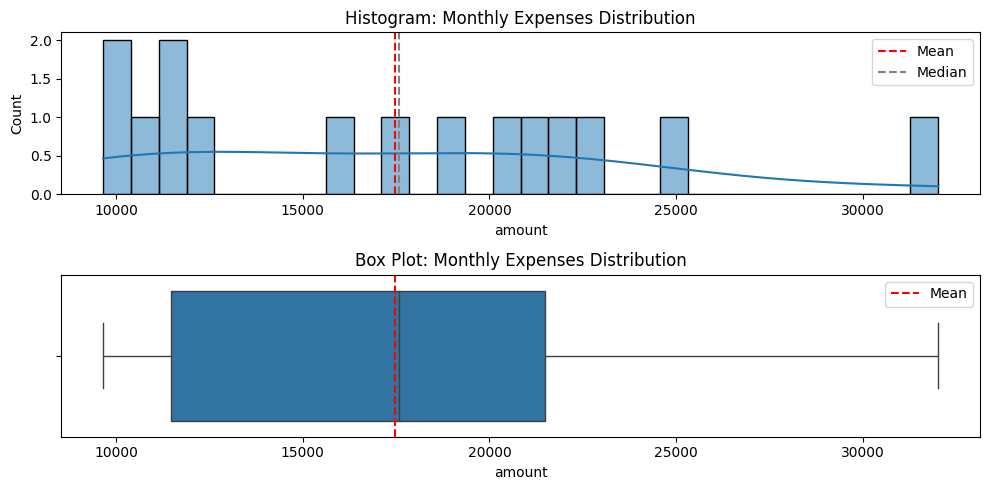

In [15]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution')

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)  #<- Printing statistics summary for Monthly Expenses with rounding to 2 decimal places
stats_monthly_expen.stat_summary.round(2)

### Descriptive Interpretation
- ⚠️**Sample size is $15$.**
    - Sample size is too small to for normally distributed data.
    - **Risky to safely consider a distribution as normally distributed.**

- ⚠️**Skewness is $0.57$.**
    - The distribution is **mildly skewed to the right**.
    - It is **beyond from $0$ to $0.5$** to be considered as roughly normal.

- ✅**Kurtosis is $-0.42$.**
    - It is between $0$ and $-1$ and much nearer to $0$.
        - The **tail of the distribution is roughly normal**.
            - The mean is not pulled much away by the data on the extremes.
            - The **mean and standard deviation of the data is still reliable dispite being mildly skewed**.

- ✅**Mean-median gap is $1$%.**
    - The gap is $<10%$, median is not distant to the mean.
        - This **further reinforces that mean is still reliable** as the distribution's central tendency.
    - Using parametric tests and CI in this data could still be reliable if inferences and modeling are needed.

- **Mean is $\text{Php}\: 17,458$**.
    - **Monthly expenses is around $\text{Php}\: 17,458$ on average.**

- **Standard Deviation is $\text{Php}\: 6,540$.**
    - The average variation of uncertainty from the mean.
    - **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**

- **IQR of $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$.**
    - **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

- **In Summary:**
    - Mean and standard deviation are still reliable dispite the distribution's mild skewness.
        - Using mean and standard deviation are still reliable for descriptive statistics.
        - Using parametric tests and CI in this data could be shaky and not ideal, but can still be utilized if inferences are needed.
    - **Monthly expenses is around $\text{Php}\: 17,458$ on average.**
    - **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**
    - **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

### **Monthly Expenses Regression Plot**
Building model to analyze the trends.

Text(0.5, 0, 'Months passes over time')

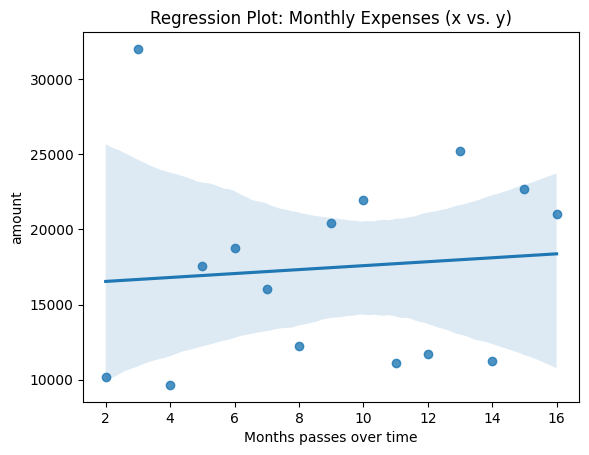

In [16]:
# Regression Plot
sns.regplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='amount')
plt.title('Regression Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months passes over time')

### Linear Regression Test
Checking regression line's accuracy 
- Raw Linear regression (x vs. y model)

In [17]:
# Checking Regression Line's Accuracy
reg_expen = scistat.linregress(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['amount'])  #<- Regression
slope_expen = reg_expen.slope               #<- slope (rate of change as x changes)
intercept_expen = reg_expen.intercept       #<- y-intercept

# Terminal Output
print(f"y = {slope_expen:.3f}x + {intercept_expen:.3f}")
print(f"R = {reg_expen.rvalue: .3f}")
print(f"R^2 = {reg_expen.rvalue ** 2: .4f}")

y = 131.264x + 16276.955
R =  0.090
R^2 =  0.0081


In [18]:
# Appending Predictions and Residuals for Better Data Visualization
y_pred = (grpby_expen_by_month['date sort no.'] * slope_expen) + intercept_expen    #<- y prediction calculation 
resid = grpby_expen_by_month['amount'] - y_pred                                     #<- Residuals calculation

grpby_expen_by_month['y pred'] = y_pred                                             #<- Appending y prediction
grpby_expen_by_month['resid'] = resid                                               #<- Appending residuals
grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid
0,23/11,10181,2,16539.483333,-6358.483333
1,23/12,32023,3,16670.747619,15352.252381
2,24/1,9647,4,16802.011905,-7155.011905
6,24/2,17583,5,16933.276190,649.723810
7,24/3,18789,6,17064.540476,1724.459524
8,24/4,16059,7,17195.804762,-1136.804762
9,24/5,12242,8,17327.069048,-5085.069048
10,24/6,20411,9,17458.333333,2952.666667
11,24/7,21985,10,17589.597619,4395.402381
12,24/8,11107,11,17720.861905,-6613.861905


Text(0, 0.5, 'Residuals')

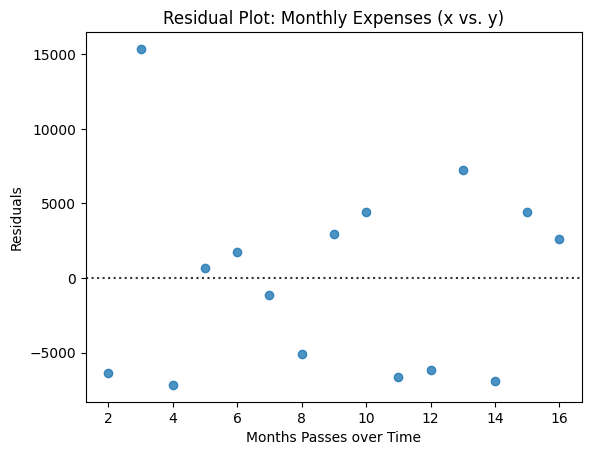

In [19]:
# Residual Plotting to Check How Scattered the Estimate Around the Model
sns.residplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='resid')
plt.title('Residual Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals')

In [20]:
# Calculating RMSE, MAE and NRME
r2_raw = metrics.r2_score(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred'])
rmse = np.sqrt(np.sum(grpby_expen_by_month['resid']**2)/len(grpby_expen_by_month['resid']))
mae = np.sum(np.abs(grpby_expen_by_month['resid'])) / len(grpby_expen_by_month['resid'])
nrmse = rmse / stats_monthly_expen.mean

# Terminal Output
print('Summary of Descriptive Stats and Metric Calculation:')                                       #<- Descriptive Statistics
print(f" - Mean Monthly Expenses = {stats_monthly_expen.mean:.3f}")
print(f" - Standard Deviation of Monthly Expenses (std)= Php {stats_monthly_expen.std:.3f}")

print('\nRegression Metrics:')                                                                      #<- Regression Metrics
print(f" - R^2 = {r2_raw: .3f}")
print(f" - Root Mean Square Error (RMSE) = {rmse:.3f}")
print(f" - Mean Absolute Error (MAE) = {mae:.3f}")
print(f" - mean-Normalized Root Mean Squarer Error (NRMSE) = {nrmse * 100:.2f}%\n")

print("Checking if RMSE < std:")                                                                    #<- Check RMSE vs std
print(f' - RMSE < std = {rmse:.3f} < {stats_monthly_expen.std:.3f} =  {rmse < stats_monthly_expen.std}')
print(f" - Percent difference = {(1 - (rmse/stats_monthly_expen.std)) * 100:.2f}%")                 #<- Percent difference between RMSE and std

Summary of Descriptive Stats and Metric Calculation:
 - Mean Monthly Expenses = 17458.333
 - Standard Deviation of Monthly Expenses (std)= Php 6540.107

Regression Metrics:
 - R^2 =  0.008
 - Root Mean Square Error (RMSE) = 6292.840
 - Mean Absolute Error (MAE) = 5251.202
 - mean-Normalized Root Mean Squarer Error (NRMSE) = 36.04%

Checking if RMSE < std:
 - RMSE < std = 6292.840 < 6540.107 =  True
 - Percent difference = 3.78%


### Model Metric Interpretation (x vs. y model):
- ✅**RMSE is $3.78$% less than standard deviation.**
    - Translating how much uncertainty or error the model have compared to mean as an estimator.
    - The model have $3.4$% less error, therefore it is better than using the mean to predict a value.
    - $3.78$% is too small difference, it means **the model is barely better than using mean as an estimator**.

- ⚠️ **$R^2$ is $0.8$%.**
    - The model explains nothing about the variance in expenses.
    - The **model isn't capturing any meaningful pattern.**

- ⚠️**NRMSE is approx. $36.04$%.**
    - Usually, $<10$% is considered excellent
        - $10–20$% is good, and 
        - $>30$% is considered poor prediction in many domains.
    - The average prediction error is about $36.69$% of the target mean value.
    - This could mean that if the mean expenses is approximately $\text{Php}\; 17,000$, then the **prediction is approximately $\text{Php}\; 6,100$ off on average**, when accounting for large mistakes.

- ✅**Residual Plot: Scattered Around the Model.**
    - The model doesn't have clear structural bias.
    - The model doesn't misfitting the trend. 

### Overall Assessment:
- **The model is barely better than using mean as an estimator**.
    - It is slightly reduced error compared to them mean as an estimator.
- Usable, but expect nothing when it comes to the precision. 
- Further feature exploration or alternative models are recommended.

## Data Transformation Attempt: x vs. log(y)
An attempt for exploring alternative predicting models and reducing the raw linear regression model's RMSE.

,y/m,amount,date sort no.,y pred,resid,log
0,23/11,10181,2,16539.483333,-6358.483333,9.228279
1,23/12,32023,3,16670.747619,15352.252381,10.374210
2,24/1,9647,4,16802.011905,-7155.011905,9.174402
6,24/2,17583,5,16933.276190,649.723810,9.774688
7,24/3,18789,6,17064.540476,1724.459524,9.841027
8,24/4,16059,7,17195.804762,-1136.804762,9.684025
9,24/5,12242,8,17327.069048,-5085.069048,9.412628
10,24/6,20411,9,17458.333333,2952.666667,9.923829
11,24/7,21985,10,17589.597619,4395.402381,9.998116
12,24/8,11107,11,17720.861905,-6613.861905,9.315331


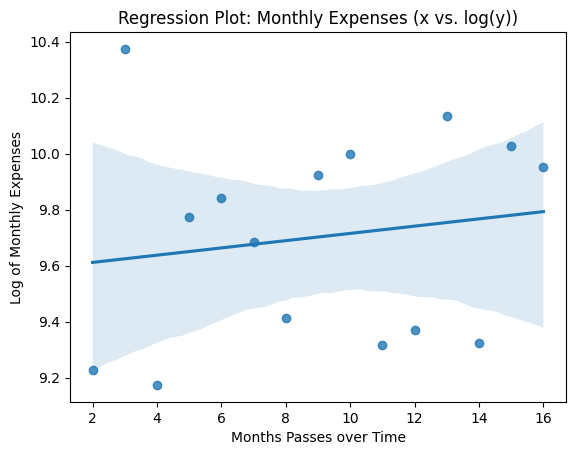

In [21]:
# Transforming Y with log() base 10
grpby_expen_by_month['log'] = np.log(grpby_expen_by_month['amount'])

# Scatter Plot Visulization with Approximate Linear Regression
sns.regplot(x=grpby_expen_by_month['date sort no.'], y=np.log(grpby_expen_by_month['amount']))
plt.title('Regression Plot: Monthly Expenses (x vs. log(y))')
plt.xlabel('Months Passes over Time')
plt.ylabel('Log of Monthly Expenses')

grpby_expen_by_month

In [22]:
# Modeling log(y)
model_monthly_expen = LinearRegression()
model_monthly_expen.fit(X=grpby_expen_by_month['date sort no.'].values.reshape(-1, 1), y=grpby_expen_by_month['log'])

log_y_coef = model_monthly_expen.coef_[0]               #<- Coefficient
log_y_intrcpt = model_monthly_expen.intercept_          #<- Intercept

print(f"y = e^({log_y_coef:.3f}x + {log_y_intrcpt:.3f})")        #<- Terminal Output (Transformed Model)

y = e^(0.013x + 9.586)


In [23]:
# Appending y Prediction from log and Its Residuals to the DataFrame
grpby_expen_by_month['y pred (log)'] = np.exp(log_y_coef * grpby_expen_by_month['date sort no.'] + log_y_intrcpt)   #<- Calc y predictions
grpby_expen_by_month['resid (log)'] = grpby_expen_by_month['amount'] - grpby_expen_by_month['y pred (log)']         #<- Appending

grpby_expen_by_month

,y/m,amount,date sort no.,y pred,resid,log,y pred (log),resid (log)
0,23/11,10181,2,16539.483333,-6358.483333,9.228279,14940.412156,-4759.412156
1,23/12,32023,3,16670.747619,15352.252381,10.374210,15135.260864,16887.739136
2,24/1,9647,4,16802.011905,-7155.011905,9.174402,15332.650735,-5685.650735
6,24/2,17583,5,16933.276190,649.723810,9.774688,15532.614909,2050.385091
7,24/3,18789,6,17064.540476,1724.459524,9.841027,15735.186961,3053.813039
8,24/4,16059,7,17195.804762,-1136.804762,9.684025,15940.400901,118.599099
9,24/5,12242,8,17327.069048,-5085.069048,9.412628,16148.291185,-3906.291185
10,24/6,20411,9,17458.333333,2952.666667,9.923829,16358.892716,4052.107284
11,24/7,21985,10,17589.597619,4395.402381,9.998116,16572.240853,5412.759147
12,24/8,11107,11,17720.861905,-6613.861905,9.315331,16788.371418,-5681.371418


Text(0, 0.5, 'Residuals (log)')

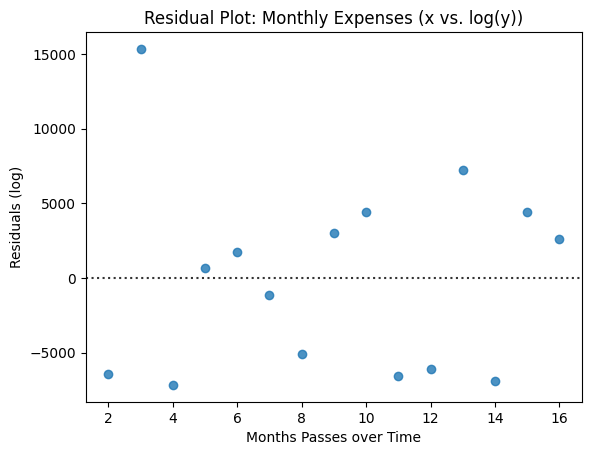

In [24]:
# Residual Plot of y Prediction
sns.residplot(x=grpby_expen_by_month['date sort no.'], y=grpby_expen_by_month['resid (log)'])
plt.title('Residual Plot: Monthly Expenses (x vs. log(y))')
plt.xlabel('Months Passes over Time')
plt.ylabel('Residuals (log)')

In [25]:
# Regression Metrics Calculation
rval_log_y, _ = scistat.pearsonr(grpby_expen_by_month['date sort no.'].values, grpby_expen_by_month['log'])
r2_log_y = metrics.r2_score(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
rmse_log_y = metrics.root_mean_squared_error(y_true=grpby_expen_by_month['amount'], y_pred=grpby_expen_by_month['y pred (log)'])
nrmse_log_y = rmse_log_y/grpby_expen_by_month['amount'].mean()

# Terminal Output
print('Monthly Expenses Stats (Php):')                                                              #<- Stats Summary
stats_monthly_expen.print_stats(round_digit=3, skew=False, kurtosis=False, mean_median_gap=False)   #<- Printing stats summary without skewness, kurtosis, and mean-median gap

print('\nRegression Metrics:')                                                                      #<- Regression Metrics
print(f" - R = {rval_log_y:.4f}")
print(f" - R^2 = {r2_log_y * 100:.2f}%")
print(f" - RMSE = {rmse_log_y:,.2f}")
print(f" - NRMSE = {nrmse_log_y * 100:.2f}")

print('\nChecking RMSE vs. std')                                                                    #<- Checking RMSE vs Std
print(f' - RMSE < std = {rmse_log_y:.3f} < {stats_monthly_expen.std:.3f} =  {rmse_log_y < stats_monthly_expen.std}')
print(f" - Percent difference = {(1 - (rmse_log_y/stats_monthly_expen.std)) * 100:.2f}%")           #<- Percent difference between RMSE and std

Monthly Expenses Stats (Php):
Mean = 17,458.333
Standard Deviation = 6,540.107

Regression Metrics:
 - R = 0.1548
 - R^2 = -2.28%
 - RMSE = 6,390.00
 - NRMSE = 36.60

Checking RMSE vs. std
 - RMSE < std = 6390.003 < 6540.107 =  True
 - Percent difference = 2.30%


### Model Metric Interpretation (x vs. log(y) model):
- 🚩 **$R^2$ is $-2.28$%.**
    - **Negative $R^2$ is worse than a flat mean guess.**
    - The model doesn't catch meaningful patterns of the data.

- ⚠️ **NRMSE is approximately $36.6$%.**
    - Larger than what we would want, which is $<30$%.
    - This could mean that if the average expenses is $\text{Php}\; 15,000$, then the **prediction is approximately $\text{Php}\; 5,500$ off on average**, when accounting for large mistakes.

- ⚠️ **RMSE is $2.3$% less than standard deviation.**
    - The model have $2.3$% less average error than the mean have.
        - **The model is better than using mean as an estimator in terms of average prediction error**.
            - Though the mean catches more meaningful pattern of the data than the model does.
        - Though, $2.3$% difference away from mean is too small.
        - The model barely have less error than the mean.

- ✅Residual Plot: Scattered arount the model.
    - The model likely have no clear structural bias.
    - The model doesn't misfitting the trend.

### Overall Assessment:
- It is better to use mean an estimator than this model.
- Though the model predicts less error, but it doesn't capture meaningful pattern of the data.
- The model seems to not show any bias.
- Raw linear regression is better than this model.
- **Failed attempt to reduce the raw linear regression model's RMSE.**

### **Model Selection for Monthly Expenses**
- Choosing the best model to interpret monthly expenses data.

In [26]:
# Storing Model Version to DataFrame
models_vers = {'Model Version': ['linereg_v1_raw', 'linereg_v2_log_y'],      #<- Storing model version to DataFrame
               'Note': ['x vs. log(y)', 'x vs. log(y)'],
               'slope': [slope_expen, log_y_coef], 
               'intercept': [intercept_expen, log_y_intrcpt],
               'R':[reg_expen.rvalue, rval_log_y], 
               'R^2': [reg_expen.rvalue ** 2, r2_log_y],
               'RMSE': [rmse, rmse_log_y],
               'NRMSE': [nrmse, nrmse_log_y]}  

model_ver_data = pd.DataFrame(models_vers)                                  #<- DataFrame for the models

# Terminal Output
model_ver_data                                                              

,Model Version,Note,slope,intercept,R,R^2,RMSE,NRMSE
0,linereg_v1_raw,x vs. log(y),131.264286,16276.954762,0.089759,0.008057,6292.839633,0.360449
1,linereg_v2_log_y,x vs. log(y),0.012957,9.585910,0.154833,-0.022812,6390.002577,0.366014


### Model Selection Summary:
- Since `linereg_v1_raw` is best models so far:
    - **`linereg_v1_raw` will be used for regression analysis of our data.**
    - `linereg_v2_log_y` is a fail attempt to reduce the raw linear regression's RMSE.

- Review the metrics summary here:
    - Go to [Model Metric Interpretation (x vs. y model)](###model-metric-interpretation-(x-vs.-y-model):)
    - Go to [Model Metric Interpretation (x vs. log(y) model)](###model-metric-interpretation-(x-vs.-log(y)-model):)

### **Monthly Expenses Regression Analysis**
Using raw regression model (x vs. y)

,Model Version,Note,slope,intercept,R,R^2,RMSE,NRMSE
0,linereg_v1_raw,x vs. log(y),131.264286,16276.954762,0.089759,0.008057,6292.839633,0.360449


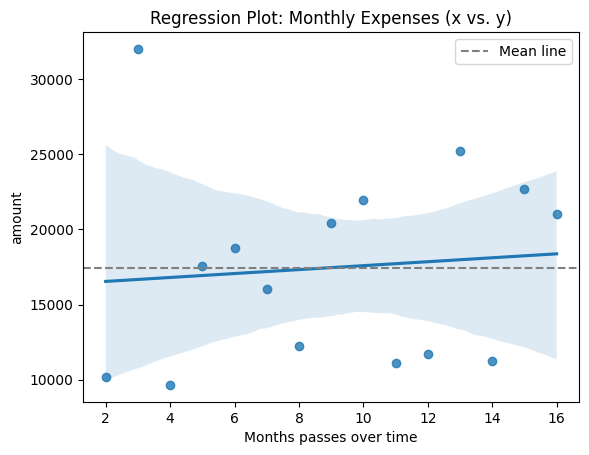

In [27]:
# Regression Plot
sns.regplot(data=grpby_expen_by_month, x=grpby_expen_by_month['date sort no.'], y='amount')
plt.title('Regression Plot: Monthly Expenses (x vs. y)')
plt.xlabel('Months passes over time')
plt.axhline(grpby_expen_by_month['amount'].mean(), color='gray', linestyle='--', label='Mean line')
plt.legend()

# Filtering to show the raw linear model
model_raw = model_ver_data[model_ver_data['Model Version'] == model_ver_data['Model Version'].iloc[0]]

# Terminal Output 
model_raw

### Discriptive Interpretation:
- **$r$ is approximately $0.0898$.**
    - Measures the strength and direction of the model.
        - Positive $r$: y increases as x increases.
        - Negative $r$: y decreases as x increases.
    - The amount of monthly expenses increases as months passes.
        - **The monthly expenses is slightly increases overtime**.
        - $r$ is near $0$, it mean slinghtly increases as x increases.
        - We can also see slightly higher values on the right end from the mean line.

- **RMSE is approximately $0$.**
    - The model explains nothing about the variance in expenses.
    - The **model isn't capturing any meaningful patterns at all**.

- **Slope is approximately $\text{Php}\: 131.26$.**
    - Measures how much y increases or decreases in every 1 unit increase of x.
    - **This means every 1 unit increase in number of months, the amount increases by $131.26$ on average.**

- **In Summary:**
    - **The monthly expenses is slightly increases overtime**.
    - Although, **the model isn't capturing any meaningful patterns at all**.
    - **In every 1 unit increase in number of months, the amount increases by $131.26$ on average.**

## **Confidence Interval (CI)**
#### What is the true monthly expenses?

Mean = 17,458.33
Standard Deviation = 6,540.11
Skewness = 0.57
Kurtosis = -0.42
Mean-Median Gap = 0.01


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

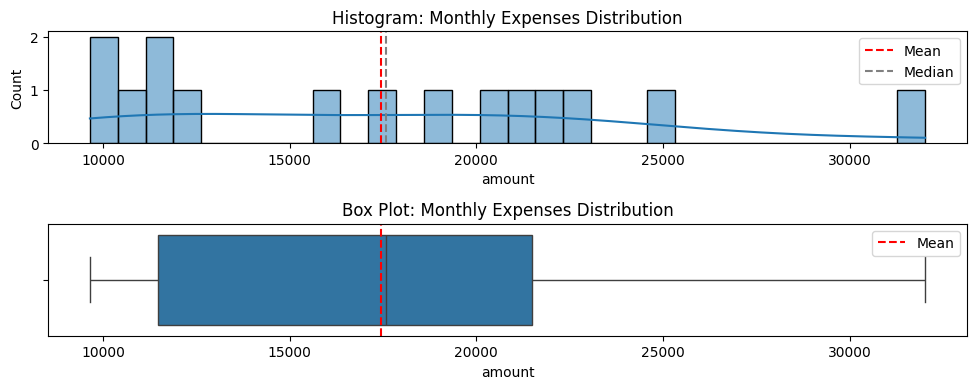

In [28]:
# Distribution Check with Distribution Plot
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution', fig_size=(10, 4))

# Terminal Output
stats_monthly_expen.print_stats(round_digit=2)
stats_monthly_expen.stat_summary.round(2)

### Distribution Interpretation Summary:
- Mean and standard deviation are still reliable dispite the distribution's mild skewness.
    - Using mean and standard deviation are still reliable for descriptive statistics.
    - Using parametric tests and CI in this data could be shaky and not ideal, but can still be utilized if inferences are needed.
- **Monthly expenses is around $\text{Php}\: 17,458$ on average.**
- **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**
- **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

### **Estimating the True Monthly Expenses Average by Using Bootstrap Confidence Interval (CI)**
- The distribution can be assumed as normal in descriptive analysis, analysts should **analyze with caution when drawing inference**.
- Non-parametric CI, like **bootstrap, would be the safest route to avoid misleading inferences**.

In [29]:
# Bootstrap Confidence Interval
sample = np.random.choice(grpby_expen_by_month['amount'],                               #<- Random sampling simulation 
                          size=(10_000 , len(grpby_expen_by_month['amount'])), replace=True)
btsrp_means = sample.mean(axis=1)                                           #<- Mean of samples means

ci_lower = np.percentile(btsrp_means, ((1 - .95)/2) * 100)                  #<- Lower interval
ci_upper = np.percentile(btsrp_means, (1 - ((1 - .95)/2)) * 100)            #<- Upper interval

approx_moe = (ci_upper - ci_lower) / 2                                      #<- MOE approximation

# Terminal Output
print(f"95% Bootstrap CI:")
print(f" - Lower bound = {ci_lower:,.2f}")
print(f" - Upper bound = {ci_upper:,.2f}")

95% Bootstrap CI:
 - Lower bound = 14,385.25
 - Upper bound = 20,652.61


### Inferential Interpretation:
- There's **$95$% confidence that the confidence interval procedure captures the true average monthly expenses**.
    - $95$% does not mean the chance of capturing.
    - It means if we sample from the population many times, then get the CI each of those trials, $95$% out of those trials will capture the true population mean.
- The **confidence interval is between around $\text{Php}\: 14,400$ and around $\text{Php}\: 20,700$**, where the true average lies.

### **Bootstrapping Visualization:**

BOOTSTRAP SAMPLING STATISTIC SUMMARY:
Mean = 17,433.543
Standard Deviation = 1,629.439
Skewness = 0.171
Kurtosis = -0.056
Mean-Median Gap = 0.003

Bootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php 14,385.255
 - Upper Bound = Php 20,652.612



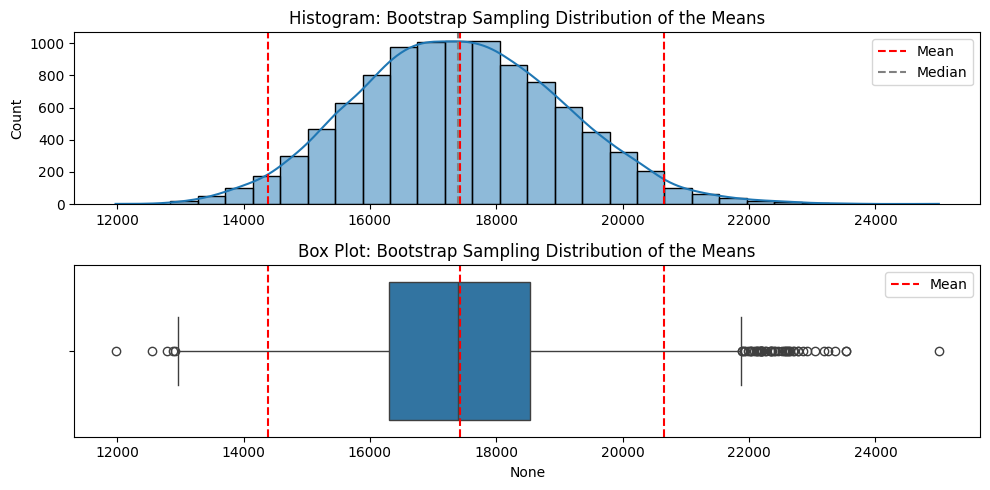

In [30]:
# Setting Statistic Summary of the Bootstrap Sampling
btsrp_means_stats =  StatsSummary(pd.Series(btsrp_means))

# Histogram Plotting
plot_distribution(btsrp_means_stats.data, plot_title='Bootstrap Sampling Distribution of the Means', ci=(ci_lower,  ci_upper))

# Terminal Output
print('BOOTSTRAP SAMPLING STATISTIC SUMMARY:')
btsrp_means_stats.print_stats(round_digit=3)

print(f"""\nBootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php {ci_lower:,.3f}
 - Upper Bound = Php {ci_upper:,.3f}\n""")

### Descriptive Interpretation:
- ✅**Skewness is around $0.17$.**
    - Values is between $0$ and $0.5$.
    - It is **roughly normally distributed**.

- ✅**Kurtosis is around $0$.**
    - Value is between $-1$ and $1$.
        - The value varies specifically between $-0.1$ and $0.1$.
    - The tailedness is **roughly normally distributed**.

- ✅**Mean-median Gap is around $0.0025$.**
    - The value is basically almost $0$.
    - There is a very slight distance between mean and median.
        - **The distribution is likely symmetric.**

- **Overall Assessment:**
    - The distribution is roughly normal.
    - **It is safe to say that the bootstrap CI is reliable.**

### Giving Context on the Bootstrap Confidence Interval

In [31]:
# Comparing CI to Mean and Standard Deviation for Context
print(f"Mean = Php {stats_monthly_expen.mean:,.3f}")                                 #<- Mean
print(f"Standard Deviation = Php {stats_monthly_expen.std:,.3f}")         #<- Std
print(f"""\nBootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php {ci_lower:,.2f}
 - Upper Bound = Php {ci_upper:,.2f}\n""")                                                                     #<- CI

# Margin of Error
print('Margin of Error:')
print(f" - MOE = {approx_moe:,.3f}")                                          #<- MOE
print(f" - % of MOE against the Mean = {approx_moe / stats_monthly_expen.mean * 100:,.2f}%")                #<- MOE / mean
print(f" - % of MOE against the Standard Deviation = {approx_moe / stats_monthly_expen.std * 100: ,.2f}%")  #<- MOE / Std

Mean = Php 17,458.333
Standard Deviation = Php 6,540.107

Bootstrap Confidence Interval (CI):                                                           
 - Lower Bound = Php 14,385.25
 - Upper Bound = Php 20,652.61

Margin of Error:
 - MOE = 3,133.678
 - % of MOE against the Mean = 17.95%
 - % of MOE against the Standard Deviation =  47.91%


### Interpretation:
- 📝**Margin of Error is around $\text{Php}\: 3,170$:**
    - MOE says that we have that amount of **uncertainty either the true monthly expenses is $3,170$ below or above** from our average estimate.

- 👍**Relative MOE** $(\frac{\text{MOE}}{\text{mean}})$:
    - Tells us the precision of the CI by comparing its MOE against the mean.
    - Usually:
        - $< 5$% --> High precision
        - $5$% - $10$% --> Acceptable precision
        - $10$% - $20$% --> Moderate uncertainty
        - $> 20$% --> High uncertainty
    - There's approximately **$18$% MOE against to mean**.
        - **Moderate uncertainty. Usable for personal finance tracking.**

- 👌 **CI width Against Standard Deviation $(\frac{\text{MOE}}{\text{std}})$:**
    - Tells us the overall spread (or noise) of MOE compared to standard deviation.
    - How informative or vague the estimate of CI.
    - Usually:
        - $< 20$% --> Excellent precision, and low variability.
        - $20$% - $50$% --> Moderate precision and variability.
        - $50$% --> CI is wide and has high variability.
    - There's **$48$% MOE against to standard deviation** (std).
        - **The CI has moderate precision but still meaningful.**

#### **Overall Assessment:**
- The CI has moderate uncertainty though still meaningful.
- The CI has moderate precision and variability.
- **There is less risk on using the CI to estimate the true monthly expenses average.**

# **Daily Expenses** 
Total daily expenses.

In [32]:
# Setting Daily Expenses DataFrame
df_daily_expen = df_expenses.groupby('y/m/d')['amount'].sum().reset_index()

# Descriptive Statistics Summary
stats_daily_expen = StatsSummary(df_daily_expen['amount'])

# Terminal Output
df_daily_expen

,y/m/d,amount
0,23/11/10,73
1,23/11/13,162
2,23/11/14,25
3,23/11/15,125
4,23/11/16,55
...,...,...
229,25/1/22,129
230,25/1/24,788
231,25/1/4,9100
232,25/1/6,239


### **Data Distribution Check**

Daily Expenses Stats Summary:
count      234.00
mean      1119.12
std       2254.63
min          5.00
25%        125.00
50%        239.00
75%        691.00
max      10360.00
Name: amount, dtype: float64 

Median = 239.0
MAD = 157.0
Skewness = 2.66
Kurtosis = 5.97
Mean-Median Gap = 0.79


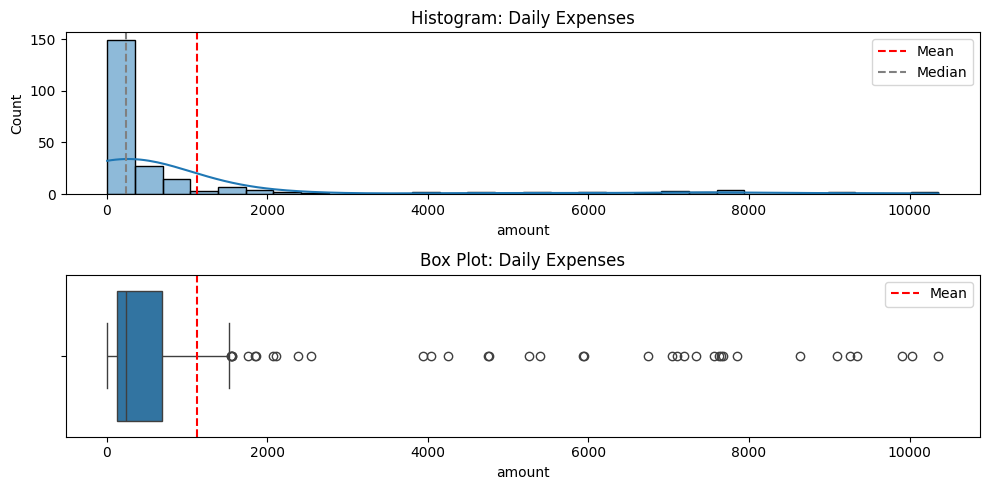

In [33]:
# Distribution Check Using Histogram and Boxplot
plot_distribution(data=stats_daily_expen.data, plot_title='Daily Expenses')

# Terminal Output
print('Daily Expenses Stats Summary:')                  
print(stats_daily_expen.stat_summary.round(2), '\n')

stats_daily_expen.print_stats(mean=False, std=False, median=True, mad=True, round_digit=2)

### Descriptive Interpretation:
- ✅There are $234$ number of samples.
    - Has enough number of samples for reliable descriptive distribution check.

- ⚠️**Skewness is $2.66$.**
    - The value is above $1$.
        - The skewness beyond this value is considered as skewed.
    - **The distribution is skewed to the right.**

- ⚠️**Kurtosis is $5.97$.**
    - The tailedness of the data distribution.
        - $>1$ means *Heavy tail*.
            - Ouliers are more concentrated from one tail.
        - From $0$ to $\pm 0.5$ means *Normal* or *roughly normal tail*.
            - Data and outliers are evenly distributed in both tails
        - $< -1$ means *Light tail*.
            - Data are more concentrated on the center and less outliers.
    - **The distribution is heavily tailed.**
    - The box plot shows the outliers in the distribution.
        - **The more outliers present, the heavier the tailedness of the distribution.**

- ⚠️**Mean-median Gap is $79$%.**
    - The gap distance between the mean and median.
    - **The value shows the mean and median are significantly distant from one another.**
        - Hints that the distribution might be skewed.

- **Median and MAD are more reliable** as central tendency and variability.
    - In the case of skewed distribution, mean and standard deviation are risky and less reliable.
        - Mean and standard deviation are sensitive to outliers.
        - The more outliers, the less reliable mean and standard deviation becomes.
    - Utilizing median (gray line) to determine the middle value of daily expenses is more stable.

- **Median is $\text{Php}\: 239$.**
    - **The middle value of daily expenses is $\text{Php}\: 239$.**

- **MAD (median absolute deviation) is $\text{Php}\: 157.$.**
    - **The daily expenses may vary either $157$ below or above the median.**

- **IQR is $\text{Php}\: 125$ and $\text{Php}\: 691$.**
    - **The $50$% typical daily expenses is between $\text{Php}\: 125$ and $\text{Php}\: 691$.**

- **In Summary:**
    - **The data distribution is skewed to the right.**
    - **Middle value of daily expenses is $\text{Php}\: 239$.**
    - **The daily expenses may vary either $\text{Php}\: 157$ below or above the median.**
    - **The typical daily expenses is between $\text{Php}\: 125$ and $\text{Php}\: 691$.**

## **Monthly `Income` Analysis**
Analysis on monthly income.

In [34]:
# Extracting Income Data and Making Separate DF
df_income = df[df['transaction'] == 'Income']

# Group by `y/m` and Sum their Amount
grpby_income = df_income.groupby('y/m')['amount'].sum().reset_index()

map_month = df.loc[:, ['y/m', 'month sort no.']].drop_duplicates().set_index('y/m').to_dict()['month sort no.'] #<- Mapping dict
grpby_income['month sort no.'] = grpby_income['y/m'].map(map_month)                                             #<- Appeding mapping to Df
grpby_income = grpby_income.sort_values(by='month sort no.').set_index('month sort no.')                        #<- Sorting values

# Setting Stats Summary of Monthly Income
stats_monthly_income = StatsSummary(grpby_income['amount'])

# Terminal Output
grpby_income

,y/m,amount
month sort no.,,
0,23/9,17732
1,23/10,25588
2,23/11,70026
3,23/12,43465
4,24/1,25466
5,24/2,25195
6,24/3,25195
7,24/4,32231
8,24/5,52230


Monthly Income Statisitc Summary (in Php):


,index,amount
0,count,17.00
1,mean,36427.47
2,std,14692.16
3,min,17732.00
4,25%,25466.00
5,50%,30278.00
6,75%,43465.00
7,max,70026.00


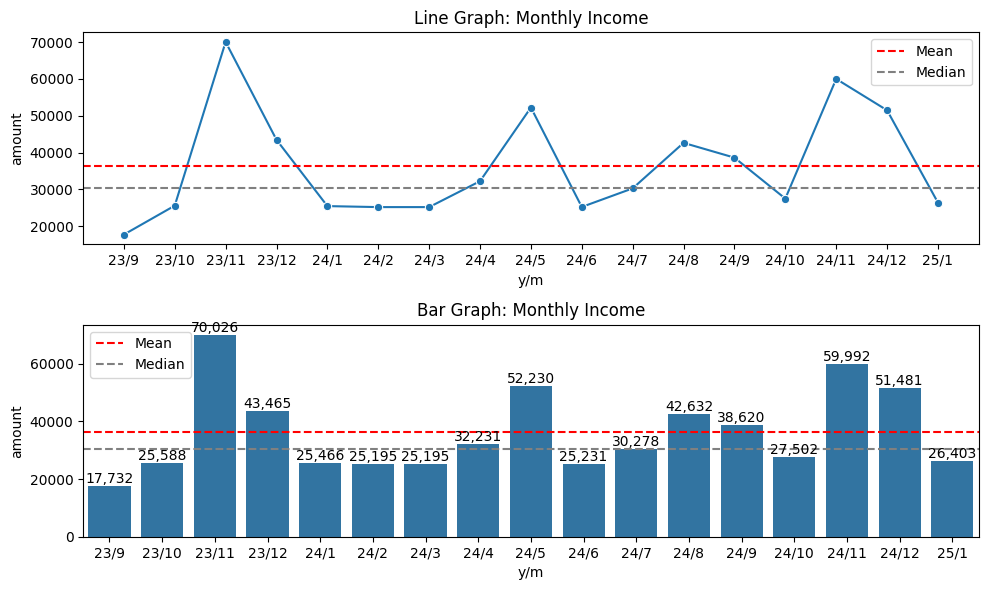

In [35]:
# Plotting Monthly Income in Line and Bar Graph
plot_line_bar(dataset=grpby_income, x='y/m', y='amount', plot_title='Monthly Income')  #<- Plotting Monthly Income

# Terminal Output
print("Monthly Income Statisitc Summary (in Php):")
stats_monthly_income.stat_summary.reset_index().round(2)

### Descriptive Interpretation:
**Line Graph**
- Income are at **highest during November and December** month of each year.
    - Could be **caused by $13th$ month pay and other incentives**.
- Monthly income has average variation of approximately $\text{Php}\;14,700$.
- The data average seems to be pulled by the high income months.
    - This indicate that data could be skewed. 
    - Visualizing with histogram and box plot would confirm it.

**Bar Graph**
- **Nov. of 2023, Nov.** and **Dec. of 2024** had higher income.
    - These are months where **there are some other source of income other than teaching**.
    - Might be the **reason why there's a large variation of monthly income**.

### Inspecting Why November and December have the Highest Monthly Income in These Years.

In [36]:
# Filtering Data that are in November and December in Any Given Year
nov_dec_income_detail = df_income[(df_income['month'] == 11) | (df_income['month'] == 12)]

# Translating Details from Foreign Script to English Alphabetical Script
detail_col_nov_dec_income = nov_dec_income_detail['details'].unique().tolist()                                  #<- Listing the `details` column

foreign_detail = {'サラリー': 'Salary', '歳末のボーナス': 'Year-end Bonus', '第十三月のサラリー': '13th Month Pay'} #<- Mapping translation

tl_detail: dict = {}                                                                                            #<- Empty dictionary
for detail in detail_col_nov_dec_income:                                                                        #<- Iterate list of `details` column 
    if detail in foreign_detail.keys():                                                                         #<- If key is in foreign script
        tl_detail[detail] = foreign_detail[detail]
    else:                                                                                                       #<- If key is in English
        tl_detail[detail] = detail

clean_nov_dec_income_detail = nov_dec_income_detail.copy()                                                      #<- Copying the filtered DF to avoid error
clean_nov_dec_income_detail['tl details'] = nov_dec_income_detail.loc[:,'details'].map(tl_detail)               #<- Appending the translated column into the DF

# Creating Pivot Table of Monthly Income Based on the Details
piv_nov_dec_income_detail = clean_nov_dec_income_detail.pivot_table(index='tl details', values='amount', columns='y/m', aggfunc=['sum', 'count']).round(2)
piv_nov_dec_income_detail

sum                            count              \
y/m                     23/11    23/12    24/11    24/12 23/11 23/12 24/11   
tl details                                                                   
13th Month Pay            NaN      NaN      NaN  25000.0   NaN   NaN   NaN   
Income (with bonus?)  44732.0      NaN      NaN      NaN   1.0   NaN   NaN   
SRI                       NaN  18000.0      NaN      NaN   NaN   1.0   NaN   
Salary                12734.0  25465.0  27992.0  26481.0   1.0   2.0   2.0   
Tahong harvest        12560.0      NaN      NaN      NaN   1.0   NaN   NaN   
Year-end Bonus            NaN      NaN  27000.0      NaN   NaN   NaN   1.0   
cash gift                 NaN      NaN   5000.0      NaN   NaN   NaN   1.0   

                            
y/m                  24/12  
tl details                  
13th Month Pay         1.0  
Income (with bonus?)   NaN  
SRI                    NaN  
Salary                 2.0  
Tahong harvest         NaN  
Year-end Bonus         NaN  
cash gift              NaN

,y/m,amount
0,23/11,70026
2,24/11,59992
3,24/12,51481
1,23/12,43465


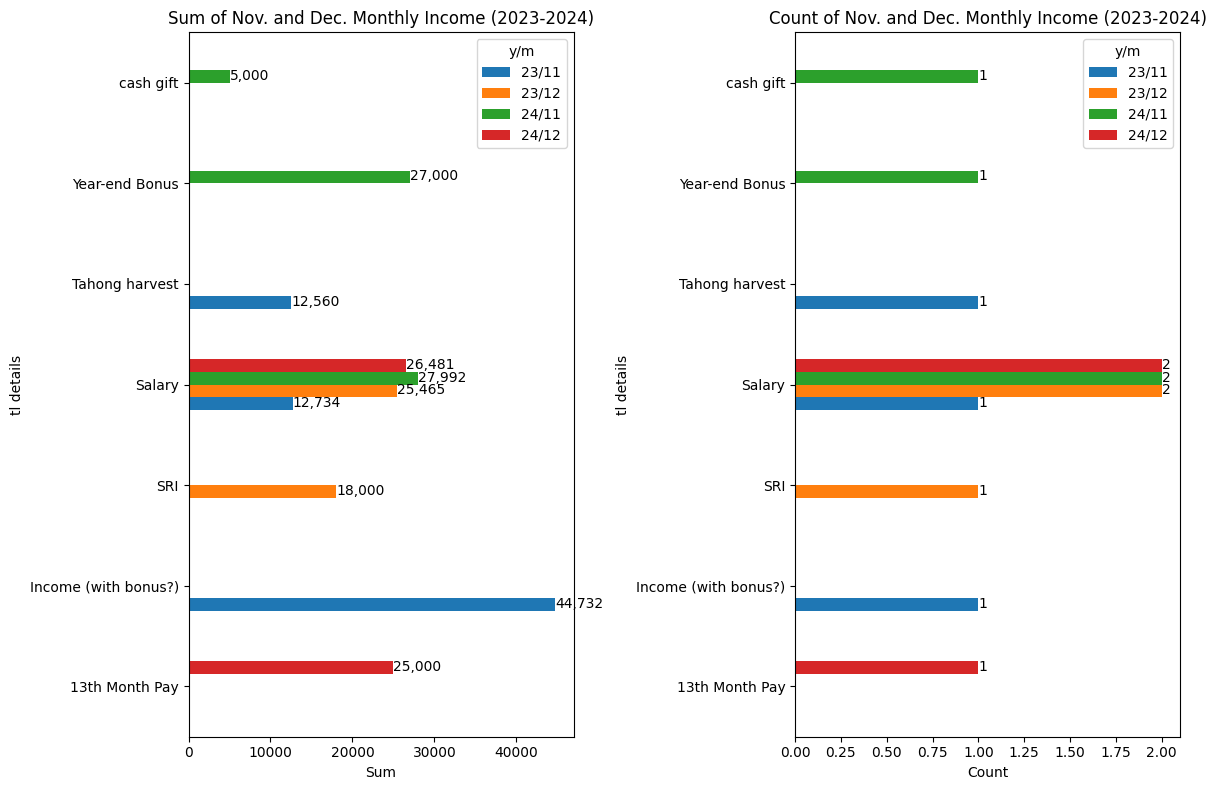

In [37]:
# Setting Subplots for Plotting
fig, ax = plt.subplots(1, 2, figsize=(12,8))

# Plotting Sum and Counts of Monthly Income Transactions
for plot, col in enumerate(['sum', 'count']):                                               #<- Iterating two columns from DF
    plt0 = piv_nov_dec_income_detail.plot(kind='barh', y=col, ax=ax[plot])

    for bar in plt0.patches:                                                                #<- Data label
        width = bar.get_width()
        if width > 0:
            plt0.text(x=width, y=bar.get_y(), s=f'{int(width):,}', va='bottom', ha='left')
    
    plt0.set_title(f'{col.capitalize()} of Nov. and Dec. Monthly Income (2023-2024)')           #<- Title
    plt0.set_xlabel(col.capitalize())                                                       #<- X-label

plt.tight_layout()

# Terminal Output
nov_dec_income_detail.groupby('y/m')['amount'].sum().reset_index().sort_values(by='amount', ascending=False)

### Descriptive Interpretation:
- **The only usual monthly income is the *Salary*.**
    - Everything else are unusuals because they are either incentives or other income source.

- **Highest monthly income among these months is $\text{November}\: 2023\: (2023/11)$.**
    - Since *Income (with bonus?)* contributed the highest among the transactions in this month by $\text{Php}\: 44,732$.
    - *Tahong harvest* is also one of the unusuals in this month's transaction and it is from the other income source.
    - ***Income (with bonus?)* and *Tahong harvest* are unsual transactions that have good amount to contribute total monthly income.**

- Comparing the November months to the December months.
    - **November months have the most unusuals that also have high amount of income.**
        - ***Income (with bonus?)*** with $\text{Php}\: 44,732$ income.
        - ***Year-end Bonus*** with $\text{Php}\: 27,000$ income.
        - ***Tahong harvest*** with $\text{Php}\: 12,560$ income.

- **In Summary:**
     - **November and December months have the highest monthly income because these are the months when incentives and other unusual income sources comes.**

### **Monthly Income Distribution**

Median = 30,278.0
MAD = 5,083.0
Skewness = 0.89
Kurtosis = -0.27
Mean-Median Gap = 0.17


count       17.00
mean     36427.47
std      14692.16
min      17732.00
25%      25466.00
50%      30278.00
75%      43465.00
max      70026.00
Name: amount, dtype: float64

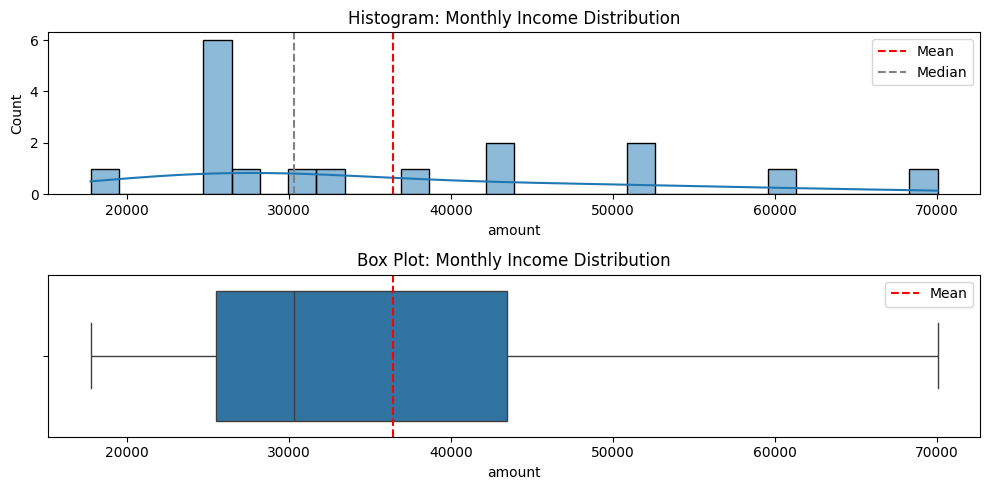

In [38]:
# Distribution Plot for Monlthy Income 
plot_distribution(data=stats_monthly_income.data, plot_title='Monthly Income Distribution')  #<- Plotting Monthly Income Distribution

stats_monthly_income.print_stats(mean=False, std=False, median=True, mad=True, round_digit=2)
stats_monthly_income.stat_summary.round(2)

#### Descriptive Interpretation:
- ⚠️**The sample size is $17$.**
    - Usually, sample size of $30$ could reveal if the distribution is at least roughly normal.
    - **$17$ sample size is not large enough to safely say it is roughly normally distributed.**

- ⚠️**Skewness is $0.89$.**
    - The value is between $0.5$ and $1$.
        - **The distribution is slightly skewed to the right.**

- ✅**Kurtosis is $-0.27$.**
    - The tailedness of the distribution.
    - The value is between $0$ and $-0.5$.
        - **The tails are roughly normal.**
        - The outliers are roughly evenly distributed in both tails (if any).

- ⚠️**Mean-median Gap is $0.17$.**
    - The gap distance between mean and median.
    - The gap value is $> 15$.
        - **The gap value is far and could indicate a strong skew.**

- 📝**Overall Distribution Assessment:** 
    - **The distribution is skewed to the right.**
    - **Median seems more reliable than using mean** in this state.

- **Median is $\text{Php}\: 30,278$.**
    - **The middle value of monthly income is $\text{Php}\: 30,278$.**

- **MAD (Median Absolute Deviation) is $\text{Php}\: 5,083$.**
    - How much monthly income spreads from median on average.
    - **The monthly income varies $\text{Php}\: 5,083$ either above or below the median $(\text{Php}\: 30,278)$.**

- **IQR is $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**
    - **Typical $50$% of monthly income is in between $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**

- **In Summary:**
    - The monthly income distribution is positively skewed.
    - **The middle value of monthly income is $\text{Php}\: 30,278$.**
    - **Monthly income varies from $\text{Php}\: 25,195$ to $\text{Php}\: 35,361$ around the median.**
    - The **typical $50$% of monthly income is in between $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**

### **Monthly Income Trend Analysis**

Text(0.5, 0, 'Month Passes over Time')

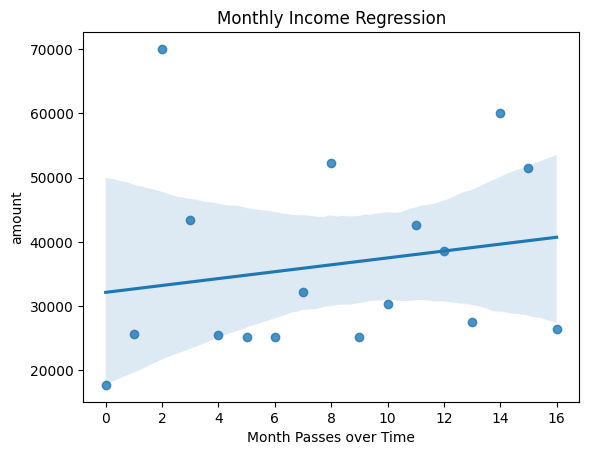

In [39]:
# Regression plot
sns.regplot(data=grpby_income, x=grpby_income.index, y='amount')
plt.title('Monthly Income Regression')
plt.xlabel('Month Passes over Time')

In [40]:
# Getting Slope and Intercep Value of Regression Line
reg_income = scistat.linregress(x=grpby_income.index, y=grpby_income['amount']) #<- Reg. line
slope_income = reg_income.slope                                                 #<- slope
intercept_income = reg_income.intercept                                         #<- y-intercept

# Terminal Output
print(f"y = {slope_income:.3f}x + {intercept_income:.3f}")
print(f"R = {reg_income.rvalue:.3f}")
print(f"R^2 = {reg_income.rvalue **2 :.3f}")

y = 536.012x + 32139.373
R = 0.184
R^2 = 0.034


In [41]:
# Amount Estimate and Residual Calcualtion
y_pred = (grpby_income.index * slope_income) + intercept_income     #<- Monthly income amount esimate
resid = grpby_income['amount'] - y_pred                             #<- Residuals

# Appending Monthly Amount Income Estimate and Residuals
grpby_income['y pred'] = y_pred                                     #<- Monthly Amount Income
grpby_income['resid'] = resid                                       #<- Residuals
grpby_income

,y/m,amount,y pred,resid
month sort no.,,,,
0,23/9,17732,32139.372549,-14407.372549
1,23/10,25588,32675.384804,-7087.384804
2,23/11,70026,33211.397059,36814.602941
3,23/12,43465,33747.409314,9717.590686
4,24/1,25466,34283.421569,-8817.421569
5,24/2,25195,34819.433824,-9624.433824
6,24/3,25195,35355.446078,-10160.446078
7,24/4,32231,35891.458333,-3660.458333
8,24/5,52230,36427.470588,15802.529412


Number of Data Points = 17
Overestimated = 10
Underestimated = 7


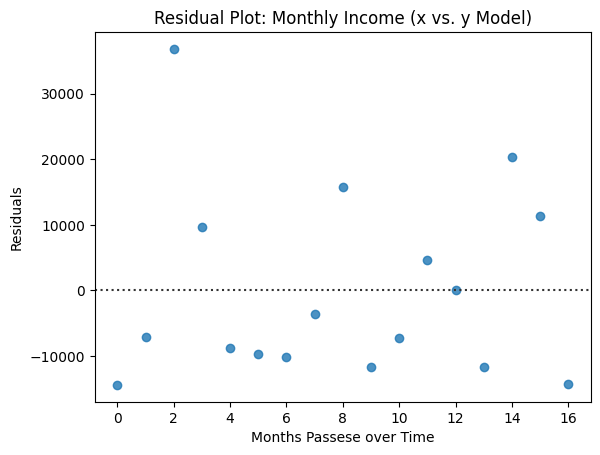

In [42]:
# Residual Plot
sns.residplot(x=grpby_income.index, y=grpby_income['resid'])
plt.title('Residual Plot: Monthly Income (x vs. y Model)')
plt.xlabel('Months Passese over Time')
plt.ylabel('Residuals')

print(f"Number of Data Points = {len(grpby_income['resid'])}")
print(f"Overestimated = {len(grpby_income.loc[grpby_income['resid'] < 0, 'amount'])}")
print(f"Underestimated = {len(grpby_income.loc[grpby_income['resid'] > 0, 'amount'])}")


### Descriptive Interpretation:
- ⚠️Residual plot **shows funnel-like pattern.**
    - The residuals are forming small residuals in early months and it increases as months passes.
        - Shows the that error variance are not constant or equal.
        - **This could mean that the linear model becomes unreliable over time.**
    - Might be due to seasonal income makes the income volatile.

- ⚠️The residual plot **shows asymmetry between the underestimated and overestimated residuals.**
    - Overestimated (below 0 residuals):
        - *There are more number of residuals.*
        - *They are less far from the 0 than the residuals above zero.*
    - Underestimated (above 0 residuals):
        - *There are less number of residuals.*
        - *Are much more further from 0 than the residuals below zero.*
    - **This suggests model bias.**
        - The model does not accounting well for a change in trend.

- **In Summary:**
    - **Residual plot alone shows the the model is no longer reliable.**
        - Skipping to check linear regression metrics since the model is not longer reliable.

### **Smoothing Data Points to Spot Trend of Monthly Income**
Smoothing the data to spot monthly income trend.

Average Monthly Income Change (5-month smoothing) = Php 551.17


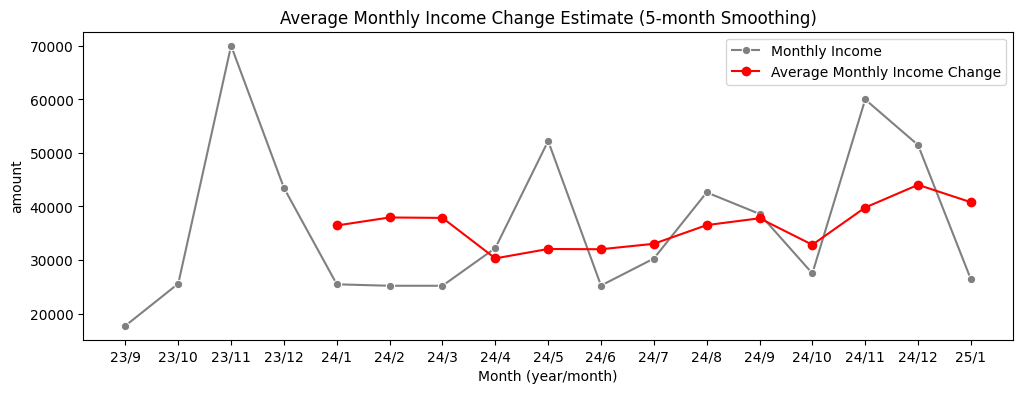

In [43]:
# Smoothing the Trend by 5 months
ave_in_5month = grpby_income['amount'].rolling(window=5).mean()

# Plotting in Line Plot
plt.figure(figsize=(12, 4))                                                                                     #<- Figure size
sns.lineplot(x=grpby_income['y/m'], y=grpby_income['amount'], label='Monthly Income', color='gray', marker='o') #<- Line plot base (Monthly income)
plt.plot(grpby_income['y/m'], ave_in_5month, label='Average Monthly Income Change', color='red', marker='o')    #<- Trend line (averages every 5-months)
plt.title('Average Monthly Income Change Estimate (5-month Smoothing)')                                         #<- Title
plt.xlabel('Month (year/month)')
plt.legend()                                                                                                    #<- Displays legend

# Terminal Output
print(f"Average Monthly Income Change (5-month smoothing) = Php {ave_in_5month.pct_change().mean() * grpby_income['amount'].mean():.2f}")

### Descriptive Interpretation:
- **The estimated average monthly income change is $\text{Php}\: 551.17$.**
    - The data is smoothed in $5$ months.
        - Showed as red line.
        - Every data point averages the income of $5$ months first before deciding the average.
            - That's why there's no data point on the first 4 months.
    - **Since it is positive, we can safely say it is increasing as month passes.**
        - The average monthly income change is around $\text{Php}\: 551.17$.

## **`G-cash` Transaction Mode**

In [44]:
# Setting Gcash Expenses DataFrame
df_gcash_expen = df[(df['transaction'] == 'Expenses') & (df['transaction_mode'] == 'G-cash')]                    #<- Filtering expenses only in gcash transactions

gcash_monthly_expen = df_gcash_expen.groupby('y/m')['amount'].sum().reset_index()   #<- Grouping by month

gcash_monthly_expen['month sort no.'] = gcash_monthly_expen['y/m'].map(map_month)   #<- Mapping by month
gcash_monthly_expen = gcash_monthly_expen.sort_values(by='month sort no.')          #<- Sorting by month

# Terminal Output
gcash_monthly_expen

,y/m,amount,month sort no.
0,23/11,1003,2
1,23/12,2663,3
2,24/1,1957,4
6,24/2,2692,5
7,24/3,1746,6
8,24/4,2246,7
9,24/5,1970,8
10,24/6,2998,9
11,24/7,2903,10
12,24/8,1762,11


### **G-cash Expenses Data Plotting**

Mean = 2,036.0
Standard Deviation = 574.38


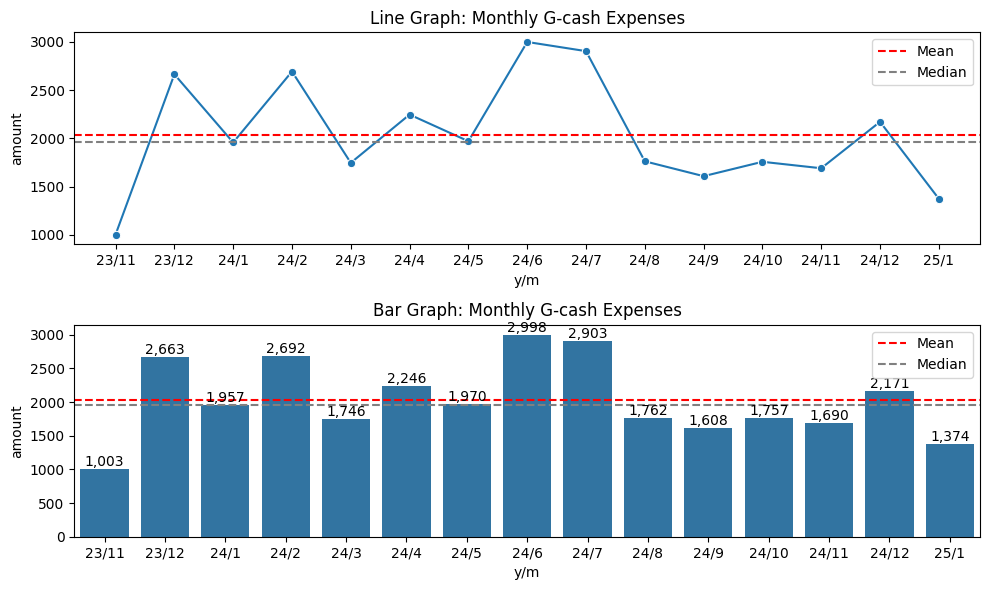

In [45]:
# Setting Summary Stat of Gcash Monthly Expenses
stats_gcash_expen = StatsSummary(gcash_monthly_expen['amount'])                     #<- Stats Summary Gcash expenses

plot_line_bar(dataset=gcash_monthly_expen, 
              x=gcash_monthly_expen['y/m'], 
              y='amount', 
              plot_title='Monthly G-cash Expenses')

# Terminal Output
stats_gcash_expen.print_stats(round_digit=2, skew=False, kurtosis=False, mean_median_gap=False)

### Descriptive Interpretation:
- **Line Graph**
    - The mean is $\text{Php}\: 2,036$.
        - **Average monthly G-cash expenses is $\text{Php}\: 2,036$.**

    - Standard deviation is $\text{Php}\: 574$.
        - Monthly G-cash expenses may vary $\text{Php}\: 574$ either above or below the $\text{Php}\: 2,036$ on average.
        - **Monthly G-cash expenses may vary between $\text{Php}\: 1,462$ and $\text{Php}\: 2,036$ on average.**

    - **Monthly G-cash expenses from $\text{Nov.}\: 2023\: (23/11)$ to $\text{Jul.}\: 2024\: (24/7)$ are fluctuating.**
        - This means that the monthly G-cash expenses are not consistent.
        - The expenses either way more or way less than the previous expenses.

    - **Monthly G-cash expenses from $\text{Aug.}\: 2024\: (24/8)$ to $\text{Nov.}\: 2024\: (24/11)$ are stabilizing.**
        - Much more consistent monthly G-cash expenses.
        - Does not necessary less than the average, but the fluctuations are less violent.
        - **These monthly expenses are also less than the average.**

- **Bar Graph**
    - The highest monthly G-cash expenses: 
        1. $\text{Jun.}\: 2024\: (\text{24/6})$ spending $\text{Php}\: 2,998$; and 
        2. $\text{Jul.}\: 2024\: (\text{24/7})$ spending $\text{Php}\: 2,903$.

### **Monthly G-cash Expenses Distribution**

Mean = 2,036.0
Standard Deviation = 574.38
Skewness = 0.2
Kurtosis = -0.78
Mean-Median Gap = 0.04

count      15.00
mean     2036.00
std       574.38
min      1003.00
25%      1718.00
50%      1957.00
75%      2454.50
max      2998.00
Name: amount, dtype: float64


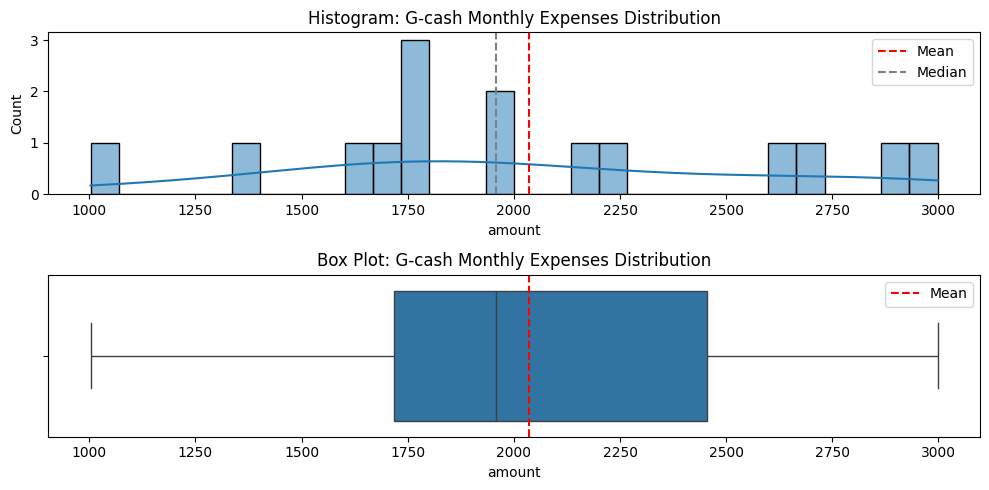

In [46]:
# Plotting Gcash Monthly Expenses Distribution
plot_distribution(data=gcash_monthly_expen['amount'], plot_title='G-cash Monthly Expenses Distribution')

# Terminal Output
stats_gcash_expen.print_stats(round_digit=2)
print(f"\n{stats_gcash_expen.stat_summary.round(2)}")

### Descriptive Interpretation:
- ⚠️**The sample size is $15$.**
    - It is less than $30$ to be safely say it forms roughly normal distribution.
        - **If the distribution is mildly skewed, this number won't help it to safely say it is normal.**

- ✅**Skewness is $0.2$.**
    - It is beyond $-0.5$ to be roughly normal, but still near it.
    - The value is between $-0.5$ and $-1$.
        - **The distribution can be considered as mildly skewed.**

- ✅**Kurtosis is $-0.78$.**
    - The tailedness of the data distribution.
    - The value is between $0$ and $1$.
        - **The distribution can be considered as light tailed.**

- ✅**Mean-median gap is $4$%.**
    - Not really a significant factor when it comes to skewness, but it gives us idea the general data distribution.
    - Reveals the general skewness of the data.
    - **$4$% means that there's less gap between mean and median.**
        - **The gap considers that the disribution is roughly normal or mildy skewed.**

- 📝**Summary Distribution Assessment:**
    - **The data distribution is roughly normal.**
    - **The mean and standard deviation are reliable for descriptive and inferential statistics.**
    - Distribution is reliable enough for parametric tests.

- **Mean is $\text{Php}\: 2,036$.**
    - **The average G-cash monthly expenses is around $\text{Php}\: 2,036$.**

- **Standard deviation is $\text{Php}\: 574.38$.**
    - The measure of variation or uncertainty of monthly expenses in G-cash.
    - **The monthly expenses in G-cash can vary approximately between $\text{Php}\: 1,461.62$ and $\text{Php}\: 2,610.38$.**

- **In Summary:**
    - The **distribution is roughly normal**.
        - The data is reliable enough for parametric tests.
    - **The average G-cash monthly expenses is around $\text{Php}\: 2,036$.**
    - **The monthly expenses in G-cash can vary approximately between $\text{Php}\: 1,461.62$ and $\text{Php}\: 2,610.38$.**

### **Inspecting Each G-cash Transaction Detail** (Monthly)
- Figuring out the behaviour of spending using e-wallet (specifically using G-cash).
- Will be split into the expenditures of each transactions made in G-cash.

In [47]:
# Grouping by Monthly Expenses Transactions
gcash_monthly_transac_expen = df_gcash_expen.groupby(['detail_clean', 'y/m'])['amount'].agg(['sum', 'mean', 'count']).reset_index()

# Aggregating Grouped by G-cash Monthly Expenses Transactions
aggr_gcash_month_trans_expen = gcash_monthly_transac_expen.groupby(['detail_clean'])['sum'].agg(['mean', 'std', 'median', 'count', 'sum']).reset_index()
aggr_gcash_month_trans_expen.round(2)

,detail_clean,mean,std,median,count,sum
0,Genshin Welkin,280.00,0.00,280.0,7,1960
1,Membership gift,258.00,NaN,258.0,1,258
2,Palaman peanut,500.00,NaN,500.0,1,500
3,Sheena,150.00,NaN,150.0,1,150
4,Spotify,236.00,11.62,239.0,15,3540
5,Steam,350.67,298.10,293.5,6,2104
6,Supa,465.27,328.97,325.0,15,6979
7,YT Membership,129.00,0.00,129.0,13,1677
8,YT sticker,15.00,NaN,15.0,1,15
9,bag,1000.00,NaN,1000.0,1,1000


#### **Appending "Others" transaction**
- Includes the transaction that have less than less than 2 count.
    - Transaction that have greater than or equal to 2 will stay as is.

In [48]:
# Setting DataFrame for Mean per Purchase Months, Monthly Total Expenses, and Expected Monthly Cost 
num_of_months = df_gcash_expen['y/m'].nunique()                                         #<- Number of Months (earliest to latest record)

others = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] < 2]        #<- Empty amount list for <1 transaction count
regulars = aggr_gcash_month_trans_expen[aggr_gcash_month_trans_expen['count'] >= 2]     #<- Empty total expenses list for <1 transaction count

clean_df_gcash = regulars.loc[:, ['detail_clean', 'mean', 'sum', 'count']]              #<- Filtering "regulars" DataFrame
clean_df_gcash.sort_values(by='sum', ascending=False).round(2)

,detail_clean,mean,sum,count
6,Supa,465.27,6979,15
15,wifi load (magic data),649.12,5193,8
14,wifi load (family access),381.50,4578,12
4,Spotify,236.00,3540,15
5,Steam,350.67,2104,6
0,Genshin Welkin,280.00,1960,7
7,YT Membership,129.00,1677,13
10,buy load,706.00,1412,2


In [49]:
# Cleaning and Filtering "others"  
dict_others_gcash = others.loc[:, 'sum'].describe().to_dict()                                   #<- Setting "others" dict
df_others_gcash = pd.DataFrame([{'detail_clean': 'Others', 'mean': dict_others_gcash['mean'],   #<- Setting "others" to DataFrame
                           'sum': others['sum'].sum(), 'count': dict_others_gcash['count']}])

# Appending "others" to "regulars" Df
if df_others_gcash['detail_clean'][0] not in clean_df_gcash['detail_clean'].to_list():          #<- Avoids appending duplicate
    clean_df_gcash2 = pd.concat([clean_df_gcash, df_others_gcash], ignore_index=True)           #<- Appending "others" to "regulars"

# Terminal Output
df_others_gcash

,detail_clean,mean,sum,count
0,Others,387.125,3097,8.0


#### **The data will be aggregated into $5$ columns:** 
1. **Mean per Purchase Months**
    - Accounting the amount of each transaction, then finding the mean.
    - Mathematical expression:
        - $\frac{1}{\text{count\: of\: transactions}} \times \sum{\text{(amount\, of\, transaction)}_{i}}$
    - Does not include the months with no purchases in the computation.

2. **Total Expenses**
    - The sum of all expenses.

3. **Transaction Count**
    - Counts of monthly active transactions.
    - Monthly active transactions have at least 1 purchase of specific transaction in a month.
        - If there is at least 1 transaction, it is considered one active month purchase.
        - If there is no purchases in that particular month, that's considered inactive month purchase.
    
4. **E(monthly cost)**
    - Expected monthly cost.
    - The approximate amount where expenses approaches as number of months increases.
    - Including the months when no purchase was done (Php 0).
      
5. **Most Frequent Purchase Amount**
    - The amount of most typical purchase of a certain transaction.
    - Purchase amount may vary but this column determines what the most frequent among those variation.

### **Computing Expected Monthly Expenses (E(monthly expenses))** 

In [ ]:
# Setting Df for E(monthly expenses) of each detail  
gcash_trans_details = df_gcash_expen['detail_clean'].unique().tolist()                  #<- Full list of details from g-cash transactions

expected_expen: dict = {}                                                               #<- Empty dict for E(monthly expenses)
wifi_load_df: dict = {'wifi load (magic data)':[], 'wifi load (family access)': []}                         #<- Empty dict for wifi load DFs

set_date_diff = relativedelta(datetime(2023, 11, 1), datetime(2025, 2, 1))              #<- Calc'ing date difference from Jan 2025 to Nov. 2023 
date_diff = abs(set_date_diff.years * 12 + set_date_diff.months)                        #<- Date difference in months (int type)
date_list = df_gcash_expen['y/m'].unique().tolist()                                     #<- Full list of dates from g-cash transactions

for detail in gcash_trans_details:
    filtered = df_gcash_expen.loc[df_gcash_expen['detail_clean'] == detail]             #<- Filter detail by iter
    agg_filtered = filtered.groupby('y/m')['amount'].agg(['count', 'sum'])              #<- Grouping by `'y/m` then aggregating
    
    if len(agg_filtered) < len(date_list):                                                  #<- Adding 0 expenses on months with no purchase
        for i in [date for date in date_list if date not in agg_filtered.index.values]:
            agg_filtered.loc[i] = [1, 0]
    
    agg_filtered['pcnt'] = agg_filtered['count'] / agg_filtered['count'].sum()          #<- Calc percentage
    agg_filtered['E(sum)'] = agg_filtered['sum'] * agg_filtered['pcnt']                 #<- Calc `'E(sum)'` column 

    if detail in wifi_load_df.keys():                                                   #<- Appeding wifi load expenses to empty dict
        for data in [filtered, agg_filtered]:
            wifi_load_df[detail].append(data)

    expected_expen[detail] = agg_filtered['E(sum)'].sum()                               #<- Appending detail to E(monthly expenses) empty dict

# Terminal Output
expected_expen

{'Spotify': 236.00000000000003,
 'Supa': 692.88,
 'YT Membership': 111.79999999999997,
 'Genshin Welkin': 130.66666666666669,
 'wifi load (magic data)': 346.2,
 'wifi load (family access)': 375.07692307692315,
 'Steam': 197.05882352941177,
 'Palaman peanut': 33.333333333333336,
 'mobile load (magic data)': 26.599999999999998,
 'Membership gift': 32.25,
 'Sheena ': 10.0,
 'welcome party aragmot': 43.333333333333336,
 'donation': 8.333333333333334,
 'bag': 66.66666666666667,
 'YT sticker': 1.0,
 'buy load': 166.11764705882354}

In [51]:
# Mapping E(monthly expenses) to "Others" DF
others['E(monthly expenses)'] = others['detail_clean'].map(expected_expen)
others

C:\Users\Acer\AppData\Local\Temp\ipykernel_185748\3467771077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others['E(monthly expenses)'] = others['detail_clean'].map(expected_expen)


,detail_clean,mean,std,median,count,sum,E(monthly expenses)
1,Membership gift,258.0,NaN,258.0,1,258,32.250000
2,Palaman peanut,500.0,NaN,500.0,1,500,33.333333
3,Sheena,150.0,NaN,150.0,1,150,10.000000
8,YT sticker,15.0,NaN,15.0,1,15,1.000000
9,bag,1000.0,NaN,1000.0,1,1000,66.666667
11,donation,125.0,NaN,125.0,1,125,8.333333
12,mobile load (magic data),399.0,NaN,399.0,1,399,26.600000
13,welcome party aragmot,650.0,NaN,650.0,1,650,43.333333


In [52]:
# Appended E(monthly expenses) to main "Others" DF
df_others_gcash['E(monthly expenses)'] = others['E(monthly expenses)'].mean()  
df_others_gcash

,detail_clean,mean,sum,count,E(monthly expenses)
0,Others,387.125,3097,8.0,27.689583


In [53]:
# Appending "Others" in E(monthly expenses) DF for Mapping
expected_expen['Others'] = df_others_gcash['E(monthly expenses)'].iloc[0]
expected_expen

{'Spotify': 236.00000000000003,
 'Supa': 692.88,
 'YT Membership': 111.79999999999997,
 'Genshin Welkin': 130.66666666666669,
 'wifi load (magic data)': 346.2,
 'wifi load (family access)': 375.07692307692315,
 'Steam': 197.05882352941177,
 'Palaman peanut': 33.333333333333336,
 'mobile load (magic data)': 26.599999999999998,
 'Membership gift': 32.25,
 'Sheena ': 10.0,
 'welcome party aragmot': 43.333333333333336,
 'donation': 8.333333333333334,
 'bag': 66.66666666666667,
 'YT sticker': 1.0,
 'buy load': 166.11764705882354,
 'Others': 27.689583333333335}

### Finalizing Table of Gcash Expenses Aggregations

In [54]:
# Renaming Columns and Appending Expected Monthly Cost
clean_df_gcash2.columns = ['details', 'mean per purchase months', 'total expenses', 'transaction count']
clean_df_gcash2['E(monthly cost)'] = clean_df_gcash2['details'].map(expected_expen)

# Appending Most Most Frequent Purchase Amount in the Df
gcash_mode_purchase = df_gcash_expen.groupby('detail_clean')['amount'].agg(lambda x: x.mode())  #<- Geting mode

gcash_expen_map = gcash_mode_purchase.to_dict()                                                 #<- Mapping dict
gcash_expen_map['buy load'] = np.median(gcash_mode_purchase['buy load'])
gcash_expen_map['Steam'] = np.median(gcash_mode_purchase['Steam'])                              #<- Median of "Steam" mode
gcash_expen_map['Others'] = others['sum'].median()                                              #<- Appending median "Others" transaction

clean_df_gcash2['Most Frequent Purchase Amount'] = clean_df_gcash2['details'].map(gcash_expen_map)  #<- Appending the most frequent purchase amount to Df

# Terminal Output
clean_df_gcash2.round(2)

,details,mean per purchase months,total expenses,transaction count,E(monthly cost),Most Frequent Purchase Amount
0,Genshin Welkin,280.00,1960,7.0,130.67,280.0
1,Spotify,236.00,3540,15.0,236.00,239.0
2,Steam,350.67,2104,6.0,197.06,193.5
3,Supa,465.27,6979,15.0,692.88,125.0
4,YT Membership,129.00,1677,13.0,111.80,129.0
5,buy load,706.00,1412,2.0,166.12,353.0
6,wifi load (family access),381.50,4578,12.0,375.08,199.0
7,wifi load (magic data),649.12,5193,8.0,346.20,599.0
8,Others,387.12,3097,8.0,27.69,328.5


### **Typical Active Monthly Transaction Count** (G-cash)
How many active months to considered to be ***active*** or ***less active***.

In [55]:
clean_df_gcash2['transaction count'].describe().round(2)

count     9.00
mean      9.56
std       4.45
min       2.00
25%       7.00
50%       8.00
75%      13.00
max      15.00
Name: transaction count, dtype: float64

### Descriptive Interpretation:
- $50$% percentile is $8$ transaction counts.
    - **We can say that the typical active monthly transaction is greater than or equal to $8$ counts.**
        - These count can be considered as **active**.
    - If transaction count is less than $8$, they can be considered as **less active**.

### **Data Visualization of Every G-cash Expenses Details**
Shows bar graph to compare each transactions.

Total Number of Months Recorded = 15 Months


,detail_clean,Most Frequent Purchase Amount
0,Genshin Welkin,280
1,Membership gift,129
2,Palaman peanut,500
3,Sheena,150
4,Spotify,239
5,Steam,"[34, 92, 144, 188, 199, 280, 399, 768]"
6,Supa,125
7,YT Membership,129
8,YT sticker,15
9,bag,1000


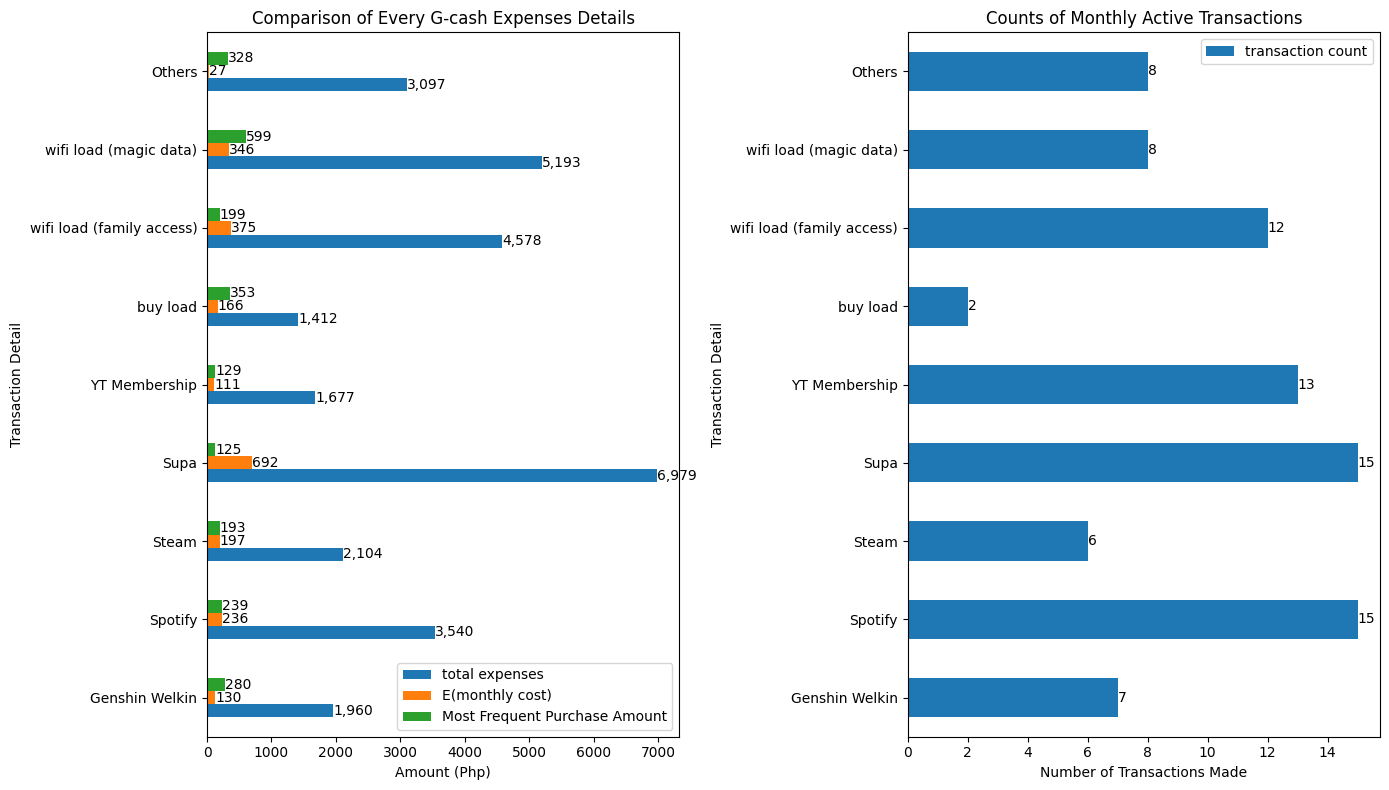

In [56]:
# Data Visualization for Mean per Purchase Months, Total Expenses, and Expected Monthly Cost
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Horizontal Bar Plot of Mean per Purchase Months and Expected Monthly Cost
ax0 = clean_df_gcash2.plot(kind='barh', x='details', 
                           y=['total expenses', 'E(monthly cost)', 'Most Frequent Purchase Amount'], 
                           ax=ax[0])
for bar in ax0.patches:
    width = bar.get_width()
    ax0.text(x=width, y=bar.get_y() + (bar.get_height()/2), s=f'{int(width):,}', va='center', ha='left')
ax0.set_xlabel('Amount (Php)')
ax0.set_ylabel('Transaction Detail')
ax0.set_title('Comparison of Every G-cash Expenses Details')

# Horizontal Bar Plot of Expected Monthly Cost
ax1 = clean_df_gcash2.plot(kind='barh', x='details', y='transaction count', ax=ax[1])
for bar in ax1.patches:
    width = bar.get_width()
    ax1.text(x=width, y=bar.get_y() + (bar.get_height()/2), s=f'{int(width):,}', va='center', ha='left')
ax1.set_xlabel('Number of Transactions Made')
ax1.set_ylabel('Transaction Detail')
ax1.set_title('Counts of Monthly Active Transactions')

plt.tight_layout()

# Terminal Output
print(f"Total Number of Months Recorded = {num_of_months} Months")

gcash_mode_purchase.loc['Others'] = others['sum'].to_list()                 #<- Appending "Others" to the mode purchase Df
gcash_mode_purchase.rename('Most Frequent Purchase Amount').reset_index()   #<- Showing the full detail of most frequent purchases amount

### Descriptive Interpretation:
- **NOTE:**
    - **On the table, there are details that have more than 1 values** of most frequent purchases amount.
        - It means there are more than 1 that have the same frequency of occuring.
    - To determine the most frequent among these values, **the analyst used their median value of these most frequent purchase amount.**

- **"*Supa*" transaction:**
    - **Total expenses is $\text{Php}\: 6,979$.**
        - Highest total expenses among G-cash transactions.
    - **Counts of monthly active transaction is $15$.**
        - **One of the highest transaction made in each month.**
        - Might be the reason why it is the highest total expenses because there were too many transactions made.
    - **Its mean per purchase months is $\text{Php}\: 465.27$.**
        - This means that in every month that I purchase this at least once, it averages about $\text{Php}\: 465.27$ expenditure.
    - **Most frequent purchase amount is $\text{Php}\: 125$.**
        - The least among the transactions.
        - This means that for every purchases, I often buy this with a price of $\text{Php}\: 125$.
        - The least single buy among the transactions.
    - **Expected monthly cost is $\text{Php}\: 692$.**
        - The highest among the transactions.
        - This means that as the number of months increases while spending things, **"*Supa*"** will have an approximate monthly cost of $\text{Php}\: 692$.
    - Despite being the highest total expenses and the most active monthly transaction, it has the least purchase amount.
    - But the expected monthly cost signals, that out of all transactions, this might be one I spend the most in each month despite its small amount each time I buy it.

- **"*Wifi load (magic data)*" vs. "*Wifi load (family access)*" transactions:**
    - **Most frequent purchase amount: $\text{Php}\: 599$ vs. $\text{Php}\: 199$.**
        - **"*Wifi load (family access)*" is definitely less** in single purchase.
    
    - **Expected monthly cost:**
        - Tells about the value of monthly cost approaches as number of months increases.
        - **"*Wifi load (magic data)*" is $\text{Php}\: 346.2$.**
        - **"*Wifi load (family access)*" is $\text{Php}\: 375$.**
        - "*Wifi load (magic data)*" is lesser.
            - This means that "*Wifi load (magic data)*" expenses in upcoming months will be around $\text{Php}\: 346.2$.
            - It is lower because there were no more purchases in later months.
        - This means as the month passes, the monthly expenses of "*Wifi load (family access)*" will be around $\text{Php}\: 346.2$, in both cases that I may buy or I may not in a certain month.
            - The same case of "*Wifi load (family access)*", but the expected monthly expenses would be $\text{Php}\: 375$.

        - **Inspecting the expected value of monthly expenses of these wifi load plans will reveal which wifi data plan is wise to buy overtime.**
            - Assumption that each of them have same number of months and purchasing at least once per month will lessen bias and have more reliable calculation.

    - **Total expenses: $\text{Php}\: 5,193$ vs. $\text{Php}\: 4,578$.**
        - "*Wifi load (family access)*" is lesser.

    - **Counts of monthly active transactions: $8$ vs. $12$.**
        - Talks about how many months the transaction have of at least one purchase in a month.
        - "*Wifi load (family access)*" is greater.
            - This means that there are more active buying months than "*Wifi load (magic data)*".
            
    - Despite having more monthly active transaction counts, total expenses of "*Wifi load (family access)*" is lesser.
    - **In general, "*Wifi load (family access)*" spends less in most ways** than "*Wifi load (magic data)*".
    - Inspecting the expected value of these wifi load plans while assuming they have equal monthly active transaction (to avoid bias) will help us decide which is better purchase.

- **In Summary:**
    - "*Supa*" may have the least amount per purchase, but it has the highest per month purchase.
        - **Minding this expenditure behaviour will help lessen the total monthly expenses in G-cash.**
    - **"*Wifi load (family access)*" seems to be less expensive overtime than "*Wifi load (magic data)*".**
        - Analyzing their expected monthly expenses could give us more certain information to decide.

### **Calculating Expected Value of Monthly Expenses of Each Wifi Load**
This will determine which wifi load expends less overtime.
    - Enables us to decide which purchase spends less

In [57]:
# Calculating the Expected Value of Each Wifi Load
expec_wifi_load: dict = {}                                                  #<- Empty dict for E(wifi load)
load_name = {'wifi load (magic data)': 'Magic Data',                        #<- Renames the wifi load name
             'wifi load (family access)': 'Family Access'}

for key, data in wifi_load_df.items():
    mode = data[0]['amount'].value_counts().index[0]                        #<- Most frequent value
    filtered = data[0]                                                      #<- Filtered data
    agg_filtered = data[1]                                                  #<- Aggregated filtered data
    
    for idx, row in agg_filtered.iterrows():                                #<- Changing no purchased months with the mode value
        if row['sum'] < 1:
            agg_filtered.loc[idx, 'sum'] = mode

    agg_filtered['E(sum)'] = agg_filtered['sum'] * agg_filtered['pcnt']     #<- Recalculating the indiv. expected value                        
    expec_wifi_load[load_name[key]] = agg_filtered['E(sum)'].sum()          #<- Appending expected value of wifi load to the empty dict

# Terminal Output
print('E(monthly expenses) of Each Wifi Load:')

for key, val in expec_wifi_load.items():
    print(f" - {key} = Php {val:,.2f}")
    print(f"    - In next 12 months = Php {val * 12:,.2f}\n")

E(monthly expenses) of Each Wifi Load:
 - Magic Data = Php 625.73
    - In next 12 months = Php 7,508.80

 - Family Access = Php 398.04
    - In next 12 months = Php 4,776.46



### Interpretation:
- Expected value tells us the average amount of something as the number of trials of it increases.
- In the records, both have the same number of months of $15$.
    - Each have at least 1 purchase of per month.
    - If 0 purchase in a month, substituted it with the most frequent single purchase.
    - This assumes that at least 1 purchase was done to avoid bias.

- Family Access have $\text{Php}\: 398.04$ expected monthly expenses.
    - This means that the average monthly expenses is $\text{Php}\: 398.04$.
    - This is the least among the two wifi load.
    - After $12$ months, it has expected value around $\text{Php}\: 4,776.46$.
        - This means that after $12$ months, this wifi load spends around $\text{Php}\: 4,776.46$.
        - Much smaller than *Magic Data* load.
    - **It is safe to say that Family Access spends less overtime than Magic Data.**
        - Subscribing Family Access load spends less overtime.

- **In Summary:**
    - **Buying Family Access load for wifi spends less overtime.**

### **Average Number of Montly Purchase**
About how many times a transaction is purchased per month on average.

Average Number of Monthly Purchase


Text(0.5, 1.0, 'Average Number of Monthly Purchases')

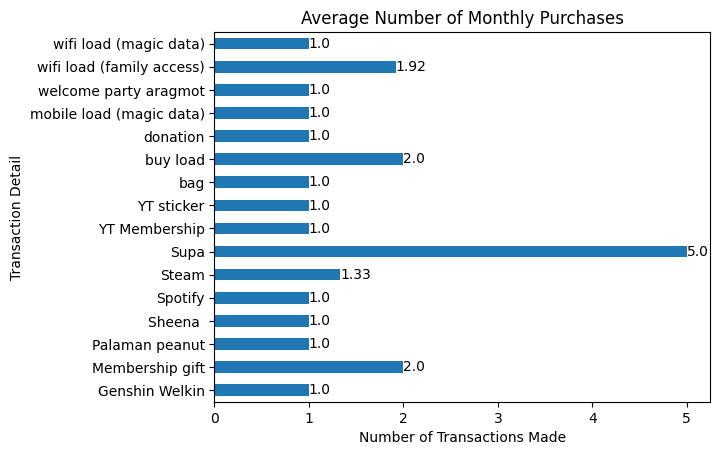

In [58]:
gcash_monthly_transac_expen[['detail_clean', 'y/m', 'count']]

ave_monthly_transaction = {}
for detail in gcash_monthly_transac_expen['detail_clean'].unique():
    ave_monthly_transaction[detail] = gcash_monthly_transac_expen[gcash_monthly_transac_expen['detail_clean'] == detail]['count'].mean().round(2)

print('Average Number of Monthly Purchase')
plot = pd.Series(ave_monthly_transaction).plot(kind='barh')
for bar in plot.patches:
    width = bar.get_width()
    plot.text(x=width, y=bar.get_y() + (bar.get_height()/2), s=f'{width.round(2)}', va='center', ha='left')
plot.set_xlabel('Number of Transactions Made')
plot.set_ylabel('Transaction Detail')
plot.set_title('Average Number of Monthly Purchases')

### Descriptive Interpretation:
- **"*Supa*" is purchased $5$ times on average.**
    - The highest number of single purchases per month.
- **"*wifi load (family access)*" is bought $1.92$ times per month on average.**
    - This proves further that even though this wifi load is purchased almost twice a month, it still have lesser expected monthly expenses.

# **Hypothesis Testing**
### **Question 1:**  
#### Is it unusual to to have less than or equal to $\text{Php}\: 10,000$ monthly expenses?

$H_0:$ **Not unusual** to have ***less than or equal to*** $\text{Php}\: 10,000$ monthly expenses.  
$H_A:$ **It is unusual** to have ***less than or equal to*** $\text{Php}\: 10,000$ monthly expenses.  
$\alpha = 0.05$

#### **Non-parametric Hypothesis Testing will be used**.
- The monthly expenses data is **not normally distributed**.

Skewness = 0.57
Kurtosis = -0.42
Mean-Median Gap = 0.01


count       15.00
mean     17458.33
std       6540.11
min       9647.00
25%      11466.00
50%      17583.00
75%      21497.50
max      32023.00
Name: amount, dtype: float64

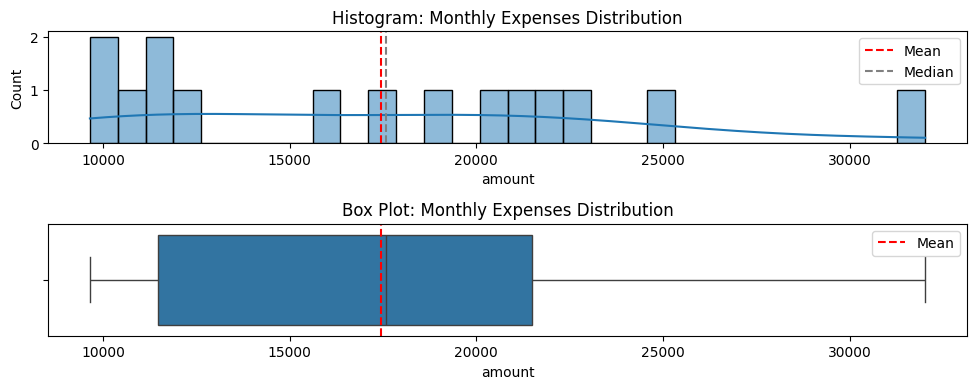

In [59]:
# Distribution Check with Distribution Plot
dict_data_expen = {'Monthly Expenses Distribution': grpby_expen_by_month['amount']}
plot_distribution(data=grpby_expen_by_month['amount'], plot_title='Monthly Expenses Distribution', fig_size=(10, 4))

# Terminal Output
stats_monthly_expen.print_stats(mean=False, std=False, round_digit=2)
stats_monthly_expen.stat_summary.round(2)

**Data Distribution Summary:**
- Mean and standard deviation are still reliable dispite the distribution's mild skewness.
    - Using mean and standard deviation are still reliable for descriptive statistics.
    - Using parametric tests and CI in this data could be shaky and not ideal, but can still be utilized if inferences are needed.
- **Monthly expenses is around $\text{Php}\: 17,458$ on average.**
- **Monthly expenses may vary on average of $\text{Php}\: 6,540$ either above or below $\text{Php}\: 17,458$.**
- **It is not unusual to have monthly expenses between $\text{Php}\: 11,466$ and $\text{Php}\: 21,497$ in a typical month.**

In [109]:
# Functions 
def interpret_pvalue(pvalue: float, alpha: float = 0.05) -> bool:
    """Checks if alpha (significance level) is less than the p-value (*default: 0.05*)."""

    if alpha < pvalue:
        print(f"Fail to Reject Null Hypothesis. alpha < p-value ({alpha} < {pvalue:.2f})")
    else:
        print(f"Reject Null Hypothesis. alpha > p-value ({alpha} > {pvalue:.2f})")


# Non-parametric Hypothesis Testing
assumed = 10_000                                                                            #<- Assumed number
diff = [x - assumed for x in grpby_expen_by_month['amount']]                                #<- List of difference of data and assumed (x - assumed)
pos = sum(d > 0 for d in diff)                                                              #<- Number of data ABOVE 0 difference
neg = sum(d < 0 for d in diff)                                                              #<- Number of data BELOW 0 difference

n = pos + neg                                                                               #<- Number of data EITHER below or above 0 difference
binom_result = scistat.binomtest(min(pos, neg), n=n, p=0.5, alternative='less')             #<- Binomial result

# Terminal Output
print(f'p-value: {binom_result.pvalue:.4f}\n')                                              #<- p-value
print(type(binom_result))
print(f'Result:')
interpret_pvalue(binom_result.pvalue)                                                       #<- alpha vs. p-value

p-value: 0.0005

<class 'scipy.stats._binomtest.BinomTestResult'>
Result:
Reject Null Hypothesis. alpha > p-value (0.05 > 0.00)


#### **Interpretation:**
- Reject null hypothesis.
- There's **NOT enough evidence** to conclude that it is **NOT unsual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.
- The data suggests that **it is unuasual** to have less than or equal to $\text{Php}\: 10,000$ monthly expenses.

### **Question 2:** 
##### When I started teaching, I have approximately $\text{Php}\: 21,000$ monthly salary (incentives not included). Does that amount is now unusual if I add up most incentives and after some changes of teacher's monthly salary from the start of my teaching career up until now?

$H_0:$ **Not unusual** to have $\text{Php}\: 21,000$ monthly income after some income changes.  
$H_A:$ **It is unusual** to have $\text{Php}\: 21,000$ monthly income after some income changes.  
$\alpha = 0.05$

##### **Parametric Hypothesis Testing will be used**
- Data distribution is **approximately normal** (skewness of ~0.147).
    - ✅Safe to assume **normality condition has been met**.
    - Though **need to check independence and random condition** to safely use parametric tests. 

Skewness = 0.89
Kurtosis = -0.27
Mean-Median Gap = 0.17


count       17.00
mean     36427.47
std      14692.16
min      17732.00
25%      25466.00
50%      30278.00
75%      43465.00
max      70026.00
Name: amount, dtype: float64

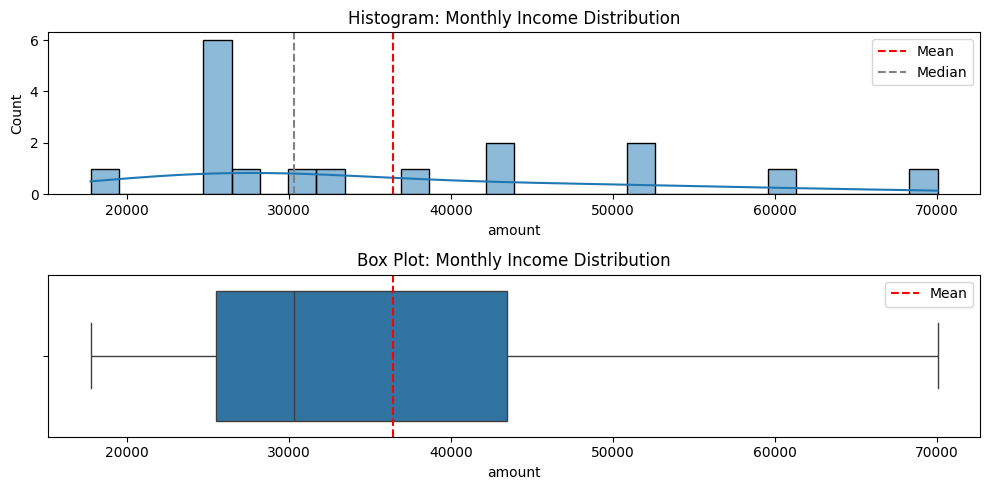

In [61]:
# Distribution Plot for Monlthy Income 
plot_distribution(data=stats_monthly_income.data, plot_title='Monthly Income Distribution')  #<- Plotting Monthly Income Distribution
stats_monthly_income.print_stats(mean=False, std=False, round_digit=2)
stats_monthly_income.stat_summary.round(2)

- **Data Distribution Summary:**
    - The monthly income distribution is positively skewed.
    - **The middle value of monthly income is $\text{Php}\: 30,278$.**
    - **Monthly income varies from $\text{Php}\: 25,195$ to $\text{Php}\: 35,361$ around the median.**
    - The **typical $50$% of monthly income is in between $\text{Php}\: 25,466$ and $\text{Php}\: 43,465$.**

Text(0.5, 1.0, 'Autocorrelation Plot of Monthly Income')

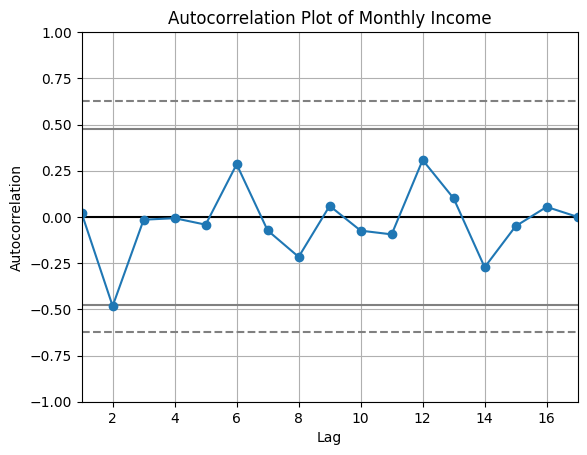

In [62]:
# Validating Independence and Random Condition via Autocorrelation Plot
pd.plotting.autocorrelation_plot(stats_monthly_income.data, marker='o')
plt.title('Autocorrelation Plot of Monthly Income')

### **Interpretation:**
- The plot tests whether the data values are correlated with their own past.
- Data points are not going beyong the border inside that spans from 0.
    - Meaning **data points are independent** from the previous data point.

✅**Independence:**
- Data are contained inside ~$\pm\; 0.49$.
- **Data points are independent** to prior data point.

✅**Randomness:**
- Data are independent in the plot.
- Randomness seems **statistically valid and justified**.

##### Hypothesis Testing:
- It is safe to assume that the **conditions of normality, independence, and randomness are met**.
- **Parametric hypothesis test would be safe to use**.
    - We'll use **1-sample t test**.

In [111]:
# 1-sample t test
confidence_lvl = 0.05

tstat, pvalue = scistat.ttest_1samp(a=stats_monthly_income.data, popmean=21_000)
print(f"p-value = {pvalue:.3f}")
print(f"Cofidence Level = {confidence_lvl}")

print('\nConclusion:')
interp_pvalue(p_value=pvalue, alpha=confidence_lvl)

p-value = 0.001
Cofidence Level = 0.05

Conclusion:
Reject Null Hypothesis. alpha < p-value is False


#### **Interpretation:**
- Reject null hypothesis.
- Data suggests that it is **likely unusual** to have $\text{Php}\: 21,000$ monthly income.
- There's **NOT enough evidence** to conclude that it is **NOT unusual** to have $\text{Php}\: 21,000$ monthly income.

In [67]:
stats_monthly_income.data.reset_index()

,month sort no.,amount
0,0,17732
1,1,25588
2,2,70026
3,3,43465
4,4,25466
5,5,25195
6,6,25195
7,7,32231
8,8,52230
9,9,25231


In [71]:
stats_monthly_income.data - 10_000

month sort no.
0      7732
1     15588
2     60026
3     33465
4     15466
5     15195
6     15195
7     22231
8     42230
9     15231
10    20278
11    32632
12    28620
13    17502
14    49992
15    41481
16    16403
Name: amount, dtype: int64

In [112]:
stat, pval = scistat.wilcoxon(x=stats_monthly_income.data - 35_000)

print(type(scistat.wilcoxon(x=stats_monthly_income.data - 35_000)))
interp_pvalue(pval)
pval

<class 'scipy.stats._morestats.WilcoxonResult'>
Fail to Reject Null Hypothesis. alpha < p-value is True


0.8683878646113217

In [98]:
test_oberseved_stat = stats_monthly_income.data.reset_index()['amount'] <= 21_000
test_oberseved_stat

0      True
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
Name: amount, dtype: bool

In [94]:
stats_monthly_income.data

month sort no.
0     17732
1     25588
2     70026
3     43465
4     25466
5     25195
6     25195
7     32231
8     52230
9     25231
10    30278
11    42632
12    38620
13    27502
14    59992
15    51481
16    26403
Name: amount, dtype: int64

[19000 25000 19500 25000 19500 19500 21500 21500 21500 20500 22000 18000]
[ True False  True False  True  True False False False  True False  True]
[23000 21500 24000 19000 25000 22000 22000 20500 24000 19500 20500 19000]
[False False False  True False False False  True False  True  True  True]
[25000 19000 24000 18000 19500 23000 21000 19000 17000 24000 19500 19000]
[False  True False  True  True False  True  True  True False  True  True]
observed_stat: 7
21000


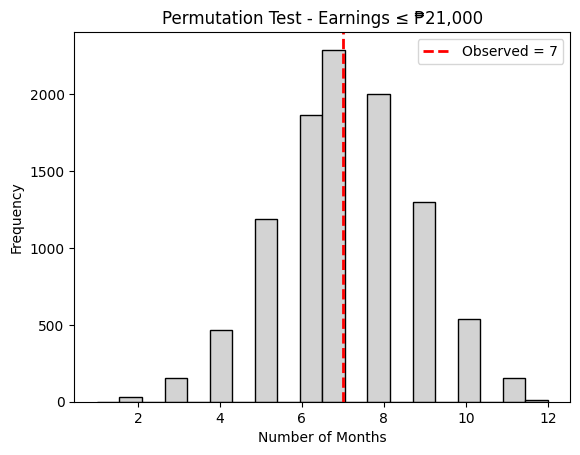

P-value: 0.6298


In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: monthly income
earnings = np.array([24000, 18000, 22000, 21000, 19500, 23000, 25000, 20000, 17000, 21500, 20500, 19000])
threshold = 21_000

# Step 1: Observed number of months earning <= ₱21,000
observed_stat = np.sum(earnings <= threshold)

# Step 2: Permutation test
n_permutations = 10000
permuted_stats = []

count = 0

for _ in range(n_permutations):
    # Shuffle the earnings
    permuted = np.random.permutation(earnings)
    
    # Randomly select same number of values as in observed_stat
    sampled = np.random.choice(permuted, size=len(earnings), replace=True)
    
    if count < 3:
        print(sampled)
        print(sampled <= threshold)
    count += 1

    # Count how many values are <= ₱21,000
    stat = np.sum(sampled <= threshold)
    permuted_stats.append(stat)

permuted_stats = np.array(permuted_stats)

# Step 3: Calculate p-value (how extreme is the observed stat?)
print(f"observed_stat: {observed_stat}")
print(threshold)
p_value = np.mean(permuted_stats >= observed_stat)

# Step 4: Plot
plt.hist(permuted_stats, bins=20, color='lightgray', edgecolor='black')
plt.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label=f'Observed = {observed_stat}')
plt.title('Permutation Test - Earnings ≤ ₱21,000')
plt.xlabel('Number of Months')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"P-value: {p_value:.4f}")


# Overall Findings
- 

In [ ]:
# file = f"C:\\Users\\Acer\\Documents\\SoftDev\\Projects\\Finance Manager dummy 2.csv"
# df = pd.read_csv(file)


# user = 'Tvan'
# password = 'Tvan217desu~'
# host = 'localhost'
# db = 'personal_finance'
# port = '3306'

# engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

# df.to_sql(name='dummy_transactions', con=engine, if_exists='replace', index=False)

# df